In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import trange
import pandas as pd
import matplotlib.ticker as ticker
import scipy as sp
import assortment_functions as af # this is the assortment_functions.py file
import matplotlib.colors as mcolors
from mpl_toolkits import mplot3d
from collections import Counter
# from numba import njit, prange

### This may produce warning signs (comment out if needed)
font = {        'size'   : 15}
import matplotlib
matplotlib.rc('font', **font)
# from matplotlib import rcParams
# rcParams.update({'figure.autolayout': True})

import scipy.io
mat = sp.io.loadmat('dynamic_parameters.mat')
par_dist = np.zeros((3,2,11))
par_dist[0,0,:] = mat['Win1'].reshape(12)[:-1]
par_dist[0,1,:] = mat['Win2'].reshape(12)[:-1]

par_dist[1,0,:] = mat['Deadlock1'].reshape(12)[:-1]
par_dist[1,1,:] = mat['Deadlock2'].reshape(12)[:-1]

par_dist[2,0,:] = mat['Lose1'].reshape(12)[:-1]
par_dist[2,1,:] = mat['Lose2'].reshape(12)[:-1]

def poll_fraction(g,n):
    party = g.nodes[n]['party']
    delta = 1 # Since the node knows it will vote for its own party
    neighbours = list(g.neighbors(n))
    for m in neighbours:
        if g.nodes[m]['party'] == party:
            delta+=1
    delta = delta/(len(neighbours)+1)
    return delta

def dynamics(g,last=False,ass=False,late=False,full_ig=False,par_mean=False):
    V = 0.6 # Super-majority
    
    T = 240 # Total length of game in seconds
    t_decision = 3.3 # The time between updates
    t = 0
    
    t_transition = 83 # Transition between early and late
    no_decisions = int(T//t_decision) # No of updates
    
    polls = np.array([poll_fraction(g,n) for n in g]) # 
    initial_parties = np.array(list(nx.get_node_attributes(g,'party').values()))
    intentions = np.zeros((no_decisions+1,len(g)))
    intentions[0,:] = initial_parties
    
    if full_ig:
        IG = np.zeros(no_decisions+1)
        IG[0] = af.influence_gap(g,absolute=False)
    
    if ass:
        assortment = np.zeros((no_decisions+1,2))
        assortment[0,:] = list(af.party_assortment(g).values())
    
    rand_numbers = np.random.rand(no_decisions+1,len(g))
    
    pars = np.zeros((3,2,len(g)))
    for i in range(3):
        for j in range(2):
            if not par_mean:
                pars[i,j,:] = np.random.choice(np.linspace(0,1,11),p=par_dist[i,j,:],size=len(g))
            else:
                pars[i,j,:] = mean_prob[i,j]
    
    phase = 0 # Early
    for t_index in range(1,no_decisions+1):
        t += t_decision
#         t_index = int(t//t_decision)
        if t > 83:
            phase = 1 # Late
            if late & (t<83+3.3):
                IG = af.influence_gap(g,absolute=False)
        pars_now = np.zeros(len(g))
        pars_now[polls>=V] = pars[0,phase,polls>=V]
        pars_now[(polls>=1-V)&(polls<V)] = pars[1,phase,(polls>=1-V)&(polls<V)]
        pars_now[polls<1-V] = pars[2,phase,polls<1-V]
        
        if full_ig:
            IG[t_index] = af.influence_gap(g,absolute=False)
        
        for n in g:
            if rand_numbers[t_index,n] <= pars_now[n]:
                intentions[t_index,n] = int(initial_parties[n])
            else:
                intentions[t_index,n] = int(1 - initial_parties[n])
        parties_dict = {n:int(intentions[t_index,n]) for n in g}
        nx.set_node_attributes(g,parties_dict,'party')
        # CORRECTION LINE 27/5/21
        polls = np.array([poll_fraction(g,n) for n in g])
        # END OF CORRECTION 27/5/21
        if ass:
            assortment[t_index,:]=list(af.party_assortment(g).values())
#         print(t_index)
#         print(initial_parties)
    if last:
        return intentions[-1,:]
    elif late:
        return IG,np.sum(intentions[-1,:])/len(g)-0.5
    elif ass:
        return assortment
    elif full_ig:
        return IG,np.sum(intentions,axis=1)/len(g) - 0.5
    else:
        return intentions

In [2]:
def dVS_gap(g,step=1):
    DG = np.zeros(len(g))
    parties = nx.get_node_attributes(g,'party')
    for n in g:
        poll_n = poll_fraction(g,n)
        if poll_n>=1/2:
            DG[n] = parties[n]
        else:
            DG[n] = 1-parties[n]
    if step <= 1:
        return np.sum(DG)/len(g) - 0.5
    else:
        h = g.copy()
        nx.set_node_attributes(h,{n:DG[n] for n in h},'party')
        return dVS_gap(h,step=step-1)
    
def wasted_vote(g,n):
    party = g.nodes[n]['party']
    neighbours = list(g.neighbors(n))
    frac = poll_fraction(g,n)
    if frac >= 1/2:
        A = 1
        B = 0
        for neigh in neighbours:
            if g.nodes[neigh]['party'] == party:
                A+=1
            else:
                B+=1
        return int(np.ceil((A-B)/2)-1)
    else:
        friends = 1
        for neigh in neighbours:
            if g.nodes[neigh]['party'] == party:
                friends += 1
        return friends

def efficiency_gap(g):
    wasted_votes = np.array([wasted_vote(g,n) for n in g])
    red_wv = [wasted_votes[n] for n in g if g.nodes[n]['party'] == 1]
    blu_wv = [wasted_votes[n] for n in g if g.nodes[n]['party'] == 0]
    return np.sum(red_wv) - np.sum(blu_wv)

In [11]:
par_means = np.zeros((3,2))
for i in range(3):
    for j in range(2):
        par_means[i,j] = np.dot(par_dist[i,j,:],np.arange(0,1.1,0.1))

In [12]:
print(par_means)

[[0.97464789 0.97883436]
 [0.96416667 0.91052632]
 [0.59770115 0.57392638]]


# Centrality Gap
Calculate the eigenvector centrality of all nodes, the 'gap' is then between the average centrality over red nodes and the average centrality over blue nodes

In [55]:
def centrality_gap(g):
    centrality = nx.eigenvector_centrality(g)
    parties = nx.get_node_attributes(g,'party')
    
    red_centrality = [centrality[n] for n in range(N) if parties[n]==1]
    blue_centrality = [centrality[n] for n in range(N) if parties[n]==0]
    
    return (np.mean(red_centrality) - np.mean(blue_centrality))/np.mean(list(centrality.values()))

In [11]:
N = 20

p0 = 1
h = 0.3
voter_skew = np.zeros(10**5)
CG = np.zeros(10**5)

for i in trange(10**5):
    node_list = np.random.choice(range(N),size=(N//2),replace=False)
    parties = {n:int(n in node_list) for n in range(N)}    
    G = af.homophilic_relaxed_caveman_graph(2,10,p0,h,parties)
    CG[i] = centrality_gap(G)
    voter_skew[i] = np.sum(dynamics(G,last=True))/N - 0.5
    
columns = ['CG','VS']
df = pd.DataFrame(data=np.concatenate((CG.reshape(10**5,1),voter_skew.reshape(10**5,1)),axis=1),columns=columns)
df.to_csv("Dynamics_CG.csv",index=False)

100%|██████████| 100000/100000 [10:25<00:00, 159.79it/s]


In [12]:
df = pd.read_csv("Dynamics_CG.csv")
CG = df['CG']
VS = df['VS']

fig = plt.figure(figsize=(5,5))
plt.scatter(CG,VS,s=5,alpha=0.5,c='orange')

r = sp.stats.linregress(CG,VS)
x = np.linspace(-0.6,0.6,100)
plt.plot(x,r.slope*x+r.intercept,'k--')

plt.xlabel('Centrality Gap')
plt.ylabel('Voter Skew')
fig.savefig("Dynamics_CG.png",bbox_inches='tight')

In [16]:
print(r)

LinregressResult(slope=0.20055874693661224, intercept=0.0006279465223239993, rvalue=0.21029770641171175, pvalue=0.0, stderr=0.0029484191224722783)


In [65]:
CG = np.zeros((10**6))
VS = np.zeros_like(CG)

N=20

for majority in trange(10):
    for i in range(10**5):
        node_list = np.random.choice(range(N),size=(N//2+majority),replace=False)
        parties = {n:int(n in node_list) for n in range(N)}    
        G = af.homophilic_relaxed_caveman_graph(2,10,1,0.3,parties)
        CG[i+majority*10**5] = centrality_gap(G)
        VS[i+majority*10**5] = np.sum(dynamics(G,last=True))/N - 0.5

 70%|███████   | 7/10 [1:18:52<33:48, 676.01s/it]


PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')

In [72]:
CG_flat = CG[:7*10**5]
VS_flat = VS[:7*10**5]
Majority = []
for i in range(7):
    Majority+=[i]*10**5
Majority=np.array(Majority)
p0 = np.array([1]*7*10**5)
df = pd.DataFrame(np.concatenate((CG_flat.reshape(7*10**5,1),VS_flat.reshape(7*10**5,1),
                                        Majority.reshape(7*10**5,1),
                                        p0.reshape(7*10**5,1)),axis=1),
                 columns=['CG','VS','Majority','Rewire'])

In [74]:
df.to_csv("Dynamics_hRCh03_CG_Majority.csv")

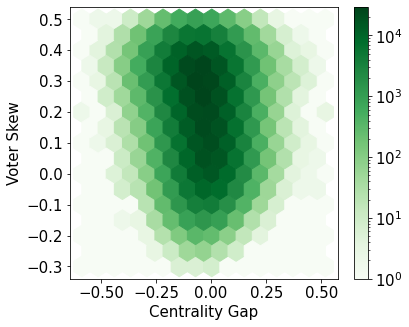

In [13]:
df = pd.read_csv("Dynamics/Correlation/Dynamics_hRCh03_CG_Majority.csv")
fig=plt.figure(figsize=(6,5))
plt.hexbin(x='CG',y='VS',gridsize=15,bins='log',cmap='Greens',data=df)
plt.xlabel("Centrality Gap")
plt.ylabel("Voter Skew")
plt.colorbar()
fig.savefig("Dynamics/Correlation/hRC_p1h03_CentralityGap.png",bbox_inches='tight')

In [18]:
print(sp.stats.linregress(df['CG'],df['VS']))
print(sp.stats.linregress(df['Majority'],df['VS']))

LinregressResult(slope=-0.2667521635547016, intercept=0.19873090694245504, rvalue=-0.1675225160728762, pvalue=0.0, stderr=0.0018763128124730433)
LinregressResult(slope=0.06146048214285712, intercept=0.023374625000000065, rvalue=0.8625482567801533, pvalue=0.0, stderr=4.3091643119030894e-05)


# Deterministic VS gap
Pretend the dynamic model is deterministic and purely jumping on a bandwagon; I will vote for the party that holds majority in my poll. The 'gap' is exactly the voter skew under 1 update step of this model.

In [4]:
def dVS_gap(g,step=1):
    DG = np.zeros(len(g))
    parties = nx.get_node_attributes(g,'party')
    for n in g:
        poll_n = poll_fraction(g,n)
        if poll_n>=1/2:
            DG[n] = parties[n]
        else:
            DG[n] = 1-parties[n]
    if step <= 1:
        return np.sum(DG)/len(g) - 0.5
    else:
        h = g.copy()
        nx.set_node_attributes(h,{n:DG[n] for n in h},'party')
        return dVS_gap(h,step=step-1)

In [42]:
N = 20

p0 = 1
h = 0.3
voter_skew = np.zeros(10**5)
DG = np.zeros(10**5)

for i in trange(10**5):
    node_list = np.random.choice(range(N),size=(N//2),replace=False)
    parties = {n:int(n in node_list) for n in range(N)}    
    G = af.homophilic_relaxed_caveman_graph(2,10,p0,h,parties)
    DG[i] = dVS_gap(G)
    voter_skew[i] = np.sum(dynamics(G,last=True))/N - 0.5
    
columns = ['DG','VS']
df = pd.DataFrame(data=np.concatenate((DG.reshape(10**5,1),voter_skew.reshape(10**5,1)),axis=1),columns=columns)
df.to_csv("Dynamics_DG.csv",index=False)

100%|██████████| 100000/100000 [08:48<00:00, 189.12it/s]


In [44]:
df = pd.read_csv("Dynamics_DG.csv")
DG = df['DG']
VS = df['VS']

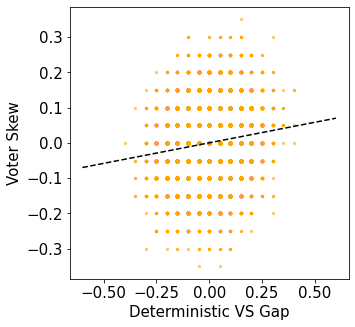

In [45]:
fig = plt.figure(figsize=(5,5))
plt.scatter(DG,VS,s=5,alpha=0.5,c='orange')

r = sp.stats.linregress(DG,VS)
x = np.linspace(-0.6,0.6,100)
plt.plot(x,r.slope*x+r.intercept,'k--')

plt.xlabel('Deterministic VS Gap')
plt.ylabel('Voter Skew')
fig.savefig("Dynamics_DG.png",bbox_inches='tight')

In [46]:
print(r)

LinregressResult(slope=0.11648513939549714, intercept=0.00018637529997526532, rvalue=0.13648237872177227, pvalue=0.0, stderr=0.0026737157783623708)


In [14]:
dVS = np.zeros((10**6))
VS = np.zeros_like(dVS)

N=20

for majority in trange(10):
    for i in range(10**5):
        node_list = np.random.choice(range(N),size=(N//2+majority),replace=False)
        parties = {n:int(n in node_list) for n in range(N)}    
        G = af.homophilic_relaxed_caveman_graph(2,10,1,0.3,parties)
        dVS[i+majority*10**5] = dVS_gap(G,step=2)
        VS[i+majority*10**5] = np.sum(dynamics(G,last=True))/N - 0.5

100%|██████████| 10/10 [1:31:27<00:00, 548.78s/it]


In [15]:
Majority = []
for i in range(10):
    Majority+=[i]*10**5
Majority=np.array(Majority)

p0 = np.array([1]*10**6)
df = pd.DataFrame(np.concatenate((dVS.reshape(10**6,1),VS.reshape(10**6,1),
                                        Majority.reshape(10**6,1),
                                        p0.reshape(10**6,1)),axis=1),
                 columns=['dVS','VS','Majority','Rewire'])
df.to_csv("Dynamics/Correlation/Dynamics_hRCh03_dVS2_Majority.csv")

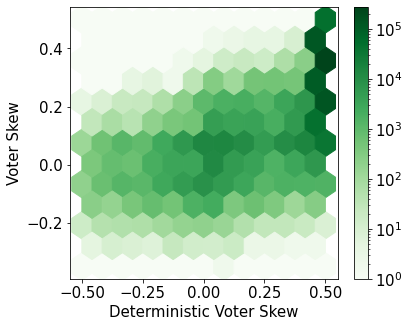

In [17]:
df=pd.read_csv("Dynamics_hRCh03_dVS2_Majority.csv")
fig=plt.figure(figsize=(6,5))
plt.hexbin(x='dVS',y='VS',gridsize=12,bins='log',cmap='Greens',data=df)
plt.colorbar()
plt.xlabel("Deterministic Voter Skew")
plt.ylabel("Voter Skew")
fig.savefig("Dynamics/Correlation/hRC_p1h03_dVS2.png",bbox_inches='tight')

In [29]:
print(sp.stats.linregress(df['dVS'],df['VS']))
print(sp.stats.linregress(df['Majority'],df['VS']))

LinregressResult(slope=0.7439870183814447, intercept=-0.01695742581058035, rvalue=0.8232298900451881, pvalue=0.0, stderr=0.0005130619336016822)
LinregressResult(slope=0.04900661515151534, intercept=0.05189738181818099, rvalue=0.893685400123868, pvalue=0.0, stderr=2.460485717246585e-05)


# Pagerank gap
Calculate pagerank of all nodes, the 'gap' is the average over red minus the average over blue.

In [7]:
def pagerank_gap(g,alpha=0.85):
    pagerank = nx.pagerank(g,alpha=alpha)
    parties = nx.get_node_attributes(g,'party')
    
    red_pr = [pagerank[n] for n in range(N) if parties[n]==1]
    blue_pr = [pagerank[n] for n in range(N) if parties[n]==0]
    
    return (np.mean(red_pr) - np.mean(blue_pr))/np.mean(list(pagerank.values()))

In [48]:
N = 20
# ps = np.arange(0.1,1.1,0.1)
# voter_skew = np.zeros((10**4,len(ps)))
# IG = np.zeros((10**4,len(ps)))

p0 = 1
h = 0.3
voter_skew = np.zeros(10**5)
PG = np.zeros(10**5)

for i in trange(10**5):
    node_list = np.random.choice(range(N),size=(N//2),replace=False)
    parties = {n:int(n in node_list) for n in range(N)}    
    G = af.homophilic_relaxed_caveman_graph(2,10,p0,h,parties)
    PG[i] = pagerank_gap(G)
    voter_skew[i] = np.sum(dynamics(G,last=True))/N - 0.5
    
columns = ['PG','VS']
df = pd.DataFrame(data=np.concatenate((PG.reshape(10**5,1),voter_skew.reshape(10**5,1)),axis=1),columns=columns)
df.to_csv("Dynamics_PG.csv",index=False)

100%|██████████| 100000/100000 [14:30<00:00, 114.89it/s]


In [49]:
df = pd.read_csv("Dynamics_PG.csv")
PG = df['PG']
VS = df['VS']

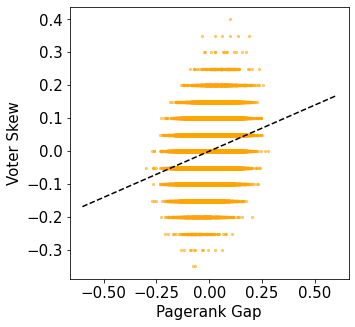

In [50]:
fig = plt.figure(figsize=(5,5))
plt.scatter(PG,VS,s=5,alpha=0.5,c='orange')

r = sp.stats.linregress(PG,VS)
x = np.linspace(-0.6,0.6,100)
plt.plot(x,r.slope*x+r.intercept,'k--')

plt.xlabel('Pagerank Gap')
plt.ylabel('Voter Skew')
fig.savefig("Dynamics_PG.png",bbox_inches='tight')

In [51]:
print(r)

LinregressResult(slope=0.2804579315312514, intercept=-0.0002486288062961157, rvalue=0.23879781254459814, pvalue=0.0, stderr=0.0036065499723211955)


# All gaps
Comparing the following gaps:
    influence,
    centrality,
    deterministic VS,
    pagerank

In [9]:
N = 20

p0 = 1
h = 0.3
voter_skew = np.zeros(10**5)
IG = np.zeros(10**5)
CG = np.zeros(10**5)
DG = np.zeros(10**5)
PG = np.zeros(10**5)

for i in trange(10**5):
    node_list = np.random.choice(range(N),size=(N//2),replace=False)
    parties = {n:int(n in node_list) for n in range(N)}    
    G = af.homophilic_relaxed_caveman_graph(2,10,p0,h,parties)
    IG[i] = af.influence_gap(G,absolute=False)
    CG[i] = centrality_gap(G)
    DG[i] = dVS_gap(G)
    PG[i] = pagerank_gap(G)
    voter_skew[i] = np.sum(dynamics(G,last=True))/N - 0.5
    
columns = ['VS','IG','CG','DG','PG']
df = pd.DataFrame(data=np.concatenate((voter_skew.reshape(10**5,1),
                                      IG.reshape(10**5,1),
                                      CG.reshape(10**5,1),
                                      DG.reshape(10**5,1),
                                      PG.reshape(10**5,1)),axis=1),columns=columns)
df.to_csv("Dynamics_alternative_metrics.csv",index=False)

100%|██████████| 100000/100000 [17:15<00:00, 96.57it/s]


In [23]:
df = pd.read_csv("Dynamics_alternative_metrics.csv")

In [29]:
r_c = sp.stats.linregress(df.IG,df.CG).rvalue
r_d = sp.stats.linregress(df.IG,df.DG).rvalue
r_p = sp.stats.linregress(df.IG,df.PG).rvalue

print(r_c)
print(r_d)
print(r_p)

0.701713729492374
0.9917876295196882
0.7688928142894218


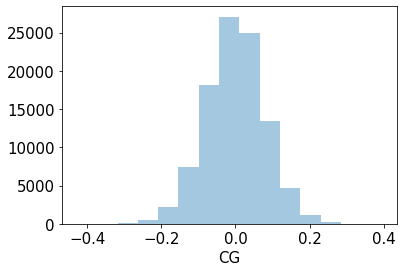

In [44]:
sns.distplot(df.CG,bins=15,kde=False)

# Efficiency Gap
A pre-existing measure of gerrymandering https://en.wikipedia.org/wiki/Wasted_vote
'Districts' in this case are treated as the polls of each person. In other words for N agents there are N districts.

In [9]:
def wasted_vote(g,n):
    party = g.nodes[n]['party']
    neighbours = list(g.neighbors(n))
    frac = poll_fraction(g,n)
    if frac >= 1/2:
        A = 1
        B = 0
        for neigh in neighbours:
            if g.nodes[neigh]['party'] == party:
                A+=1
            else:
                B+=1
        return int(np.ceil((A-B)/2)-1)
    else:
        friends = 1
        for neigh in neighbours:
            if g.nodes[neigh]['party'] == party:
                friends += 1
        return friends

def efficiency_gap(g):
    wasted_votes = np.array([wasted_vote(g,n) for n in g])
    red_wv = [wasted_votes[n] for n in g if g.nodes[n]['party'] == 1]
    blu_wv = [wasted_votes[n] for n in g if g.nodes[n]['party'] == 0]
    return np.sum(red_wv) - np.sum(blu_wv)

In [17]:
N = 20

p0 = 1
h = 0.3
voter_skew = np.zeros(10**5)
EG = np.zeros(10**5)

for i in trange(10**5):
    node_list = np.random.choice(range(N),size=(N//2),replace=False)
    parties = {n:int(n in node_list) for n in range(N)}    
    G = af.homophilic_relaxed_caveman_graph(2,10,p0,h,parties)
    EG[i] = dVS_gap(G)
    voter_skew[i] = np.sum(dynamics(G,last=True))/N - 0.5
    
columns = ['EG','VS']
df = pd.DataFrame(data=np.concatenate((EG.reshape(10**5,1),voter_skew.reshape(10**5,1)),axis=1),columns=columns)
df.to_csv("Dynamics_EG.csv",index=False)

100%|██████████| 100000/100000 [08:52<00:00, 187.73it/s]


In [20]:
df = pd.read_csv("Dynamics_EG.csv")
EG = df['EG']
VS = df['VS']

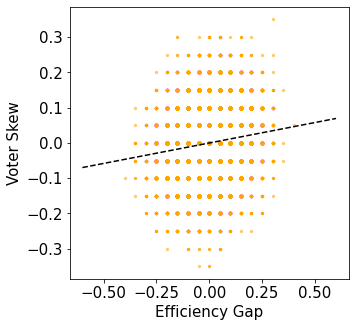

In [21]:
fig = plt.figure(figsize=(5,5))
plt.scatter(EG,VS,s=5,alpha=0.5,c='orange')
# plt.ylim([-0.2,0.2])
# plt.xlim([-0.5,0.5])

r = sp.stats.linregress(EG,VS)
x = np.linspace(-0.6,0.6,100)
plt.plot(x,r.slope*x+r.intercept,'k--')

plt.xlabel('Efficiency Gap')
plt.ylabel('Voter Skew')
fig.savefig("Dynamics_EG.png",bbox_inches='tight')

# Closeness gap
Similar to eigenvector centrality but using closeness centrality

In [47]:
def closeness_gap(g):
    closeness = nx.closeness_centrality(g)
    red_closeness = np.array([closeness[n] for n in g if g.nodes[n]['party']==1])
    blu_closeness = np.array([closeness[n] for n in g if g.nodes[n]['party']==0])
    return np.mean(red_closeness) - np.mean(blu_closeness)

In [52]:
N = 20

p0 = 1
h = 0.3
voter_skew = np.zeros(10**5)
ClG = np.zeros(10**5)

for i in trange(10**5):
    node_list = np.random.choice(range(N),size=(N//2),replace=False)
    parties = {n:int(n in node_list) for n in range(N)}    
    G = af.homophilic_relaxed_caveman_graph(2,10,p0,h,parties)
    ClG[i] = closeness_gap(G)
    voter_skew[i] = np.sum(dynamics(G,last=True))/N - 0.5
    
columns = ['ClG','VS']
df = pd.DataFrame(data=np.concatenate((ClG.reshape(10**5,1),voter_skew.reshape(10**5,1)),axis=1),columns=columns)
df.to_csv("Dynamics_ClG.csv",index=False)

100%|██████████| 100000/100000 [12:08<00:00, 137.26it/s]


In [53]:
df = pd.read_csv("Dynamics_ClG.csv")
ClG = df['ClG']
VS = df['VS']

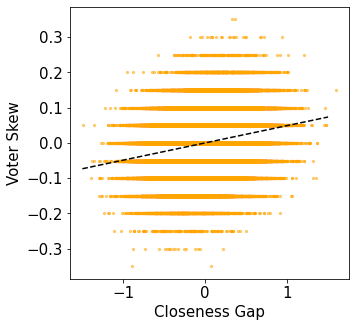

In [61]:
fig = plt.figure(figsize=(5,5))
plt.scatter(ClG*19,VS,s=5,alpha=0.5,c='orange')
# plt.ylim([-0.2,0.2])
# plt.xlim([-0.5,0.5])

r = sp.stats.linregress(ClG*19,VS)
x = np.linspace(-1.5,1.5,100)
plt.plot(x,r.slope*x+r.intercept,'k--')

plt.xlabel('Closeness Gap')
plt.ylabel('Voter Skew')
fig.savefig("Dynamics_ClG.png",bbox_inches='tight')

In [57]:
print(r)

LinregressResult(slope=0.9282344722624559, intercept=7.018517677035495e-05, rvalue=0.22324157845429599, pvalue=0.0, stderr=0.012816990248449442)


# Karate Club
Testing on the empirical dataset of the Zachary karate club graph (http://konect.cc/networks/ucidata-zachary/). More or less this graph is scale-free, small-world and has communities.

In [8]:
G = nx.karate_club_graph()
VS = np.zeros(10**5)
IG = np.zeros(10**5)
N = len(G)

for i in trange(10**5):
    node_list = np.random.choice(range(N),size=(N//2),replace=False)
    parties = {n:int(n in node_list) for n in range(N)}    
    nx.set_node_attributes(G,parties,'party')
    IG[i] = af.influence_gap(G,absolute=False)
    VS[i] = np.sum(dynamics(G,last=True))/N - 0.5
    
columns = ['IG','VS']
df = pd.DataFrame(data=np.concatenate((IG.reshape(10**5,1),
                                       VS.reshape(10**5,1)),
                                      axis=1),
                  columns=columns)
df.to_csv("Dynamics_karate.csv",index=False)

100%|██████████| 100000/100000 [10:28<00:00, 159.10it/s]


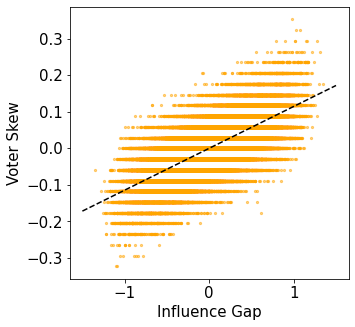

In [12]:
fig = plt.figure(figsize=(5,5))
plt.scatter(IG,VS,s=5,alpha=0.5,c='orange')
# plt.ylim([-0.2,0.2])
# plt.xlim([-0.5,0.5])

r = sp.stats.linregress(IG,VS)
x = np.linspace(-1.5,1.5,100)
plt.plot(x,r.slope*x+r.intercept,'k--')

plt.xlabel('Influence Gap')
plt.ylabel('Voter Skew')
fig.savefig("Dynamics_karate.png",bbox_inches='tight')

In [13]:
print(r)

LinregressResult(slope=0.11463207028843643, intercept=-5.289694270524342e-05, rvalue=0.6942919726019382, pvalue=0.0, stderr=0.00037576461664190345)


In [23]:
G = nx.karate_club_graph()
VS = np.zeros(10**6)
IG = np.zeros(10**6)
N = len(G)

for majority in trange(10):
    for i in range(10**5):
        node_list = np.random.choice(range(N),size=(N//2+majority),replace=False)
        parties = {n:int(n in node_list) for n in range(N)}    
        nx.set_node_attributes(G,parties,'party')
        IG[i+majority*10**5] = af.influence_gap(G,absolute=False)
        VS[i+majority*10**5] = np.sum(dynamics(G,last=True))/N - 0.5

100%|██████████| 10/10 [1:34:50<00:00, 569.05s/it]


In [25]:
Majority = []
for i in range(10):
    Majority+=[i]*10**5
Majority=np.array(Majority)

# p0 = np.array([1]*10**6)
df = pd.DataFrame(np.concatenate((IG.reshape(10**6,1),VS.reshape(10**6,1),
                                        Majority.reshape(10**6,1)),axis=1),
                 columns=['IG','VS','Majority'])
df.to_csv("Dynamics/Correlation/Dynamics_karate_supreme.csv")

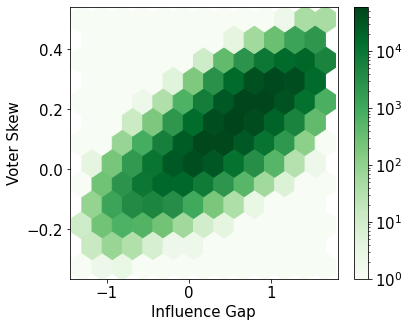

In [15]:
df=pd.read_csv("Dynamics/Correlation/Dynamics_karate_supreme.csv")
fig=plt.figure(figsize=(6,5))
plt.hexbin(x='IG',y='VS',gridsize=12,bins='log',cmap='Greens',data=df)
plt.colorbar()
plt.xlabel("Influence Gap")
plt.ylabel("Voter Skew")
fig.savefig("Dynamics/Correlation/karate.png",bbox_inches='tight')

In [31]:
print(sp.stats.linregress(df['IG'],df['VS']))
print(sp.stats.linregress(df['Majority'],df['VS']))

LinregressResult(slope=0.1860324896168758, intercept=0.05262633275513978, rvalue=0.8213444425758019, pvalue=0.0, stderr=0.00012920169675446498)
LinregressResult(slope=0.03397207308377901, intercept=0.004973759358288532, rvalue=0.8475918631412198, pvalue=0.0, stderr=2.12687909506076e-05)


# Modularity Gap
Rationale in finding the modularity as a 'gap' is that one may think of a party assignment as some partitioning of a graph into two communities. Along these lines if you imagine the topology constrains what is a good partition (so one that maximises modularity) if the 'communities' due to party assignment is not a good topological partition then one may argue its unrepresentative and thus bad.

In [61]:
def modularity_gap(g):
    Q_mat = nx.linalg.modularitymatrix.modularity_matrix(g)
    party_matrix=np.zeros((len(g),len(g)))
    for i in g:
        for j in g:
            party_matrix[i,j] = int(g.nodes[i]['party']==g.nodes[j]['party'])
    return np.sum(Q_mat*party_matrix)/(2*len(g.edges()))

In [63]:
N = 20
p0 = 1
h = 0.3

node_list = np.random.choice(range(N),size=(N//2),replace=False)
parties = {n:int(n in node_list) for n in range(N)}    
G = af.homophilic_relaxed_caveman_graph(2,10,p0,h,parties)
MG = modularity_gap(G)
print(MG)
# print(nx.linalg.modularitymatrix.modularity_matrix(G))
# print(np.sum(nx.linalg.modularitymatrix.modularity_matrix(G)))

-3.0592812234115424e-16


In [65]:
N = 20
# ps = np.arange(0.1,1.1,0.1)
# voter_skew = np.zeros((10**4,len(ps)))
# IG = np.zeros((10**4,len(ps)))

p0 = 1
h = 0.3
voter_skew = np.zeros(10**5)
MG = np.zeros(10**5)

for i in trange(10**5):
    node_list = np.random.choice(range(N),size=(N//2),replace=False)
    parties = {n:int(n in node_list) for n in range(N)}    
    G = af.homophilic_relaxed_caveman_graph(2,10,p0,h,parties)
    MG[i] = modularity_gap(G)
    voter_skew[i] = np.sum(dynamics(G,last=True))/N - 0.5
    
columns = ['MG','VS']
df = pd.DataFrame(data=np.concatenate((MG.reshape(10**5,1),voter_skew.reshape(10**5,1)),axis=1),columns=columns)
df.to_csv("Dynamics_MG.csv",index=False)

100%|██████████| 100000/100000 [11:45<00:00, 141.73it/s]


In [8]:
df = pd.read_csv('Dynamics_MG.csv')
fig = plt.figure(figsize=(5,5))
plt.scatter(MG,VS,s=5,alpha=0.5,c='orange')
# plt.ylim([-0.2,0.2])
# plt.xlim([-0.5,0.5])

r = sp.stats.linregress(MG,VS)
# x = np.linspace(-.8,.8,100)
# plt.plot(x,r.slope*x+r.intercept,'k--')

plt.xlabel('Modularity Gap')
plt.ylabel('Voter Skew')
fig.savefig("Dynamics_MG.png",bbox_inches='tight')

FileNotFoundError: [Errno 2] File Dynamics_MG.csv does not exist: 'Dynamics_MG.csv'

In [69]:
print(r)

LinregressResult(slope=-411063883144.0157, intercept=-0.00023343818693343472, rvalue=-0.002517502204998252, pvalue=0.425976582852332, stderr=516347914952.2435)


# Ising Model Hamiltonian
$H = -J\sum_{<ij>}p(i)p(j)$

In [12]:
def hamiltonian(g):
    parties = nx.get_node_attributes(g,'party')
    H = 0
    for n in g:
        if parties[n] == 0:
            parties[n] = -1
    for (i,j) in g.edges():
        H += parties[i]*parties[j]
    return H

In [15]:
N = 20
# ps = np.arange(0.1,1.1,0.1)
# voter_skew = np.zeros((10**4,len(ps)))
# IG = np.zeros((10**4,len(ps)))

p0 = 1
h = 0.3
VS = np.zeros(10**5)
H = np.zeros(10**5)

for i in trange(10**5):
    node_list = np.random.choice(range(N),size=(N//2),replace=False)
    parties = {n:int(n in node_list) for n in range(N)}    
    G = af.homophilic_relaxed_caveman_graph(2,10,p0,h,parties)
    H[i] = hamiltonian(G)
    VS[i] = np.sum(dynamics(G,last=True))/N - 0.5
    
columns = ['H','VS']
df = pd.DataFrame(data=np.concatenate((H.reshape(10**5,1),VS.reshape(10**5,1)),axis=1),columns=columns)
df.to_csv("Dynamics_hamiltonian.csv",index=False)

100%|██████████| 100000/100000 [10:25<00:00, 159.78it/s]


LinregressResult(slope=-3.421148841053947e-05, intercept=-0.00015466375197885216, rvalue=-0.003106848801252141, pvalue=0.3258723216517725, stderr=3.482203099676911e-05)


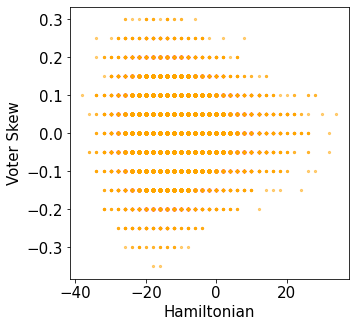

In [16]:
df = pd.read_csv("Dynamics_hamiltonian.csv")
H = df['H']
VS = df['VS']
fig = plt.figure(figsize=(5,5))
plt.scatter(H,VS,s=5,alpha=0.5,c='orange')

r = sp.stats.linregress(H,VS)
print(r)

plt.xlabel('Hamiltonian')
plt.ylabel('Voter Skew')
fig.savefig("Dynamics_hamiltonian.png",bbox_inches='tight')

# SBM
Testing on stochastic block models, another way to generate graphs with community structure.

In [41]:
sizes=[20,20]
probs = [[0.5, 0.2],
         [0.2, 0.5]]

VS = np.zeros(10**5)
IG = np.zeros(10**5)
N = 40

for i in trange(10**5):
    G = nx.stochastic_block_model(sizes,probs)
    node_list = np.random.choice(range(N),size=(N//2),replace=False)
    parties = {n:int(n in node_list) for n in range(N)}    
    nx.set_node_attributes(G,parties,'party')
    IG[i] = af.influence_gap(G,absolute=False)
    VS[i] = np.sum(dynamics(G,last=True))/N - 0.5
    
columns = ['IG','VS']
df = pd.DataFrame(data=np.concatenate((IG.reshape(10**5,1),
                                       VS.reshape(10**5,1)),
                                      axis=1),
                  columns=columns)
df.to_csv("Dynamics_SBM_N40.csv",index=False)

100%|██████████| 100000/100000 [13:05<00:00, 127.28it/s]


In [ ]:
sizes=[10,10]
probs = [[0.7, 0.2],
         [0.2, 0.7]]

VS = np.zeros(10**5)
IG = np.zeros(10**5)
N = 20

for i in trange(10**5):
    G = nx.stochastic_block_model(sizes,probs)
    node_list = np.random.choice(range(N),size=(N//2),replace=False)
    parties = {n:int(n in node_list) for n in range(N)}    
    nx.set_node_attributes(G,parties,'party')
    IG[i] = af.influence_gap(G,absolute=False)
    VS[i] = np.sum(dynamics(G,last=True))/N - 0.5
    
columns = ['IG','VS']
df = pd.DataFrame(data=np.concatenate((IG.reshape(10**5,1),
                                       VS.reshape(10**5,1)),
                                      axis=1),
                  columns=columns)
df.to_csv("Dynamics_SBM_N40.csv",index=False)

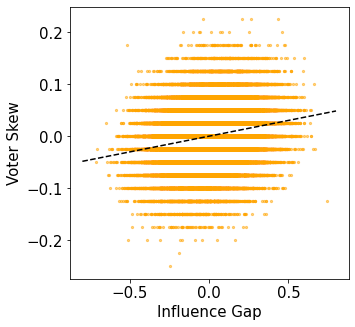

In [43]:
fig = plt.figure(figsize=(5,5))
plt.scatter(IG,VS,s=5,alpha=0.5,c='orange')
# plt.ylim([-0.2,0.2])
# plt.xlim([-0.5,0.5])

r = sp.stats.linregress(IG,VS)
x = np.linspace(-.8,.8,100)
plt.plot(x,r.slope*x+r.intercept,'k--')

plt.xlabel('Influence Gap')
plt.ylabel('Voter Skew')
fig.savefig("Dynamics_SBM_N40.png",bbox_inches='tight')

In [44]:
print(r)

LinregressResult(slope=0.060483550239386834, intercept=0.0004853105454212987, rvalue=0.20553528432212947, pvalue=0.0, stderr=0.0009107150217665056)


# Full IG,VS time plot

In [18]:
N = 20
p0 = 1
h = 0.3

IG_hrc = np.zeros((10**4,int(240//3.3 + 1)))
VS_hrc = np.zeros((10**4,int(240//3.3 + 1)))

IG_ba = np.zeros((10**4,int(240//3.3 + 1)))
VS_ba = np.zeros((10**4,int(240//3.3 + 1)))

for i in trange(10**4):
    node_list = np.random.choice(range(N),size=(N//2),replace=False)
    parties = {n:int(n in node_list) for n in range(N)}    
    g_hrc = af.homophilic_relaxed_caveman_graph(2,10,p0,h,parties)
    IG_hrc[i,:], VS_hrc[i,:] = dynamics(g_hrc,full_ig=True)

    node_list = np.random.choice(range(100),size=(100//2),replace=False)
    parties = {n:int(n in node_list) for n in range(100)}    
    g_ba = nx.barabasi_albert_graph(100,10)
    nx.set_node_attributes(g_ba,parties,'party')
    IG_ba[i,:], VS_ba[i,:] = dynamics(g_ba,full_ig=True)

100%|██████████| 10000/10000 [20:06<00:00,  8.29it/s]


In [35]:
df_IG_hrc = pd.DataFrame(IG_hrc)
df_VS_hrc = pd.DataFrame(VS_hrc)

df_IG_ba = pd.DataFrame(IG_ba)
df_VS_ba = pd.DataFrame(VS_ba)

df_IG_hrc.to_csv("Dynamics_t_IG_hrc.csv",index=False)
df_VS_hrc.to_csv("Dynamics_t_VS_hrc.csv",index=False)

df_IG_ba.to_csv("Dynamics_t_IG_ba.csv",index=False)
df_VS_ba.to_csv("Dynamics_t_VS_ba.csv",index=False)

In [57]:
T_len = int(240//3.3 + 1)
r_hrc = np.zeros(T_len)
r_ba = np.zeros(T_len)

for i in range(T_len):
    r_hrc[i] = sp.stats.linregress(IG_hrc[:,i],VS_hrc[:,-1]).rvalue
    r_ba[i] = sp.stats.linregress(IG_ba[:,i],VS_ba[:,-1]).rvalue
    
columns = ['hRC','BA']
df_r = pd.DataFrame(data=np.concatenate((r_hrc.reshape(T_len,1),
                                       r_ba.reshape(T_len,1)),
                                      axis=1),
                  columns=columns)
df_r.to_csv("Dynamics_hrcba_rt.csv",index=False)

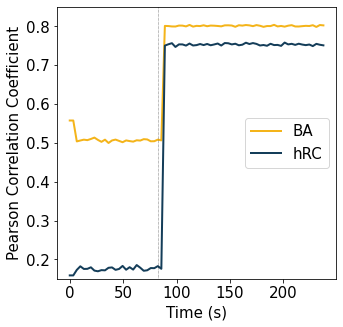

In [73]:
fig = plt.figure(figsize=(5,5))

plt.plot(np.arange(0,240,3.3),r_ba,c='#f4b41a',label='BA',lw=2)
plt.plot(np.arange(0,240,3.3),r_hrc,c='#143d59',label='hRC',lw=2)

plt.plot([83,83],[0,1],'k:',lw=0.5)
plt.ylim([0.15,0.85])

# ax=plt.gca()
# ax.set_xticks([0,50,83,100,150,200])
# ax.set_xticklabels([0,50,83,100,150,200])

plt.ylabel("Pearson Correlation Coefficient")
plt.xlabel("Time (s)")

plt.legend(loc='center right')
plt.savefig("Dynamics_hrcba_rt.png",bbox_inches='tight')

# In-phase correlations
Testing whether IG at the start of a phase i correlates strongly with the VS at the end of phase i.

In [12]:
ig_h = pd.read_csv("CSVs/Dynamics_t_IG_hrc.csv").values
vs_h = pd.read_csv("CSVs/Dynamics_t_VS_hrc.csv").values

ig_b = pd.read_csv("CSVs/Dynamics_t_IG_ba.csv").values
vs_b = pd.read_csv("CSVs/Dynamics_t_VS_ba.csv").values

In [20]:
len_early = int(83//3.3+1)
len_late = int(240//3.3) + 1

r_h0 = np.zeros(len_early)
r_h1 = np.zeros(len_late - len_early)

r_b0 = np.zeros(len_early)
r_b1 = np.zeros(len_late - len_early)

for i in range(len(r_h0)):
    r_h0[i] = sp.stats.linregress(ig_h[:,i],vs_h[:,len_early-1]).rvalue
    r_b0[i] = sp.stats.linregress(ig_b[:,i],vs_b[:,len_early-1]).rvalue
for i in range(len_early,len_late):
    r_h1[i-len_early] = sp.stats.linregress(ig_h[:,i],vs_h[:,-1]).rvalue
    r_b1[i-len_early] = sp.stats.linregress(ig_b[:,i],vs_b[:,-1]).rvalue

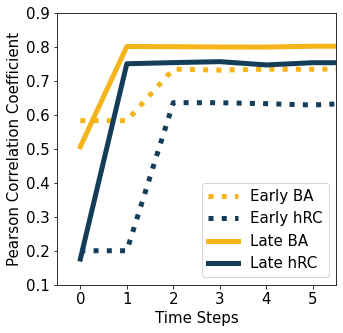

In [43]:
fig = plt.figure(figsize=(5,5))

t=np.arange(0,240,3.3)

plt.plot(range(len_early),r_b0,c='#f4b41a',ls=':',lw=5,label='Early BA')
plt.plot(range(len_early),r_h0,c='#143d59',ls=':',lw=5,label='Early hRC')

plt.plot(r_b1,c='#f4b41a',lw=5,label='Late BA')
plt.plot(r_h1,c='#143d59',lw=5,label='Late hRC')

plt.ylim([0.1,0.9])
plt.xlim([-0.5,5.5])
plt.xlabel("Time Steps")
plt.ylabel("Pearson Correlation Coefficient")
plt.legend()

plt.savefig("Dynamics_hrcba_rt_phases.png",bbox_inches='tight')

# Watts-Strogatz

WS : k=3,N=20

In [8]:
VS = np.zeros(10**5)
IG = np.zeros(10**5)
N = 20

for i in trange(10**5):
    G = nx.watts_strogatz_graph(N,3,0.3)
    node_list = np.random.choice(range(N),size=(N//2),replace=False)
    parties = {n:int(n in node_list) for n in range(N)}    
    nx.set_node_attributes(G,parties,'party')
    IG[i] = af.influence_gap(G,absolute=False)
    VS[i] = np.sum(dynamics(G,last=True))/N - 0.5
    
columns = ['IG','VS']
df = pd.DataFrame(data=np.concatenate((IG.reshape(10**5,1),
                                       VS.reshape(10**5,1)),
                                      axis=1),
                  columns=columns)
df.to_csv("Dynamics_WS_k3_N20.csv",index=False)

100%|██████████| 100000/100000 [08:08<00:00, 204.74it/s]


In [13]:
df=pd.read_csv("CSVs/Dynamics_WS_k4_N100.csv")
IG = df['IG']
VS = df['VS']

In [14]:
print(sp.stats.linregress(IG,VS))

LinregressResult(slope=0.08406647624332132, intercept=-1.0484099463394967e-05, rvalue=0.2303374754004478, pvalue=0.0, stderr=0.001123116689934025)


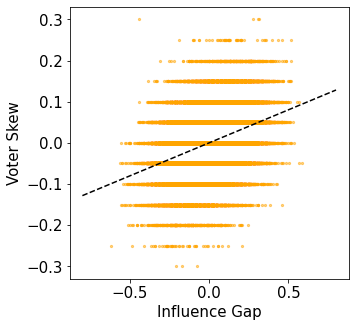

In [13]:
fig = plt.figure(figsize=(5,5))
plt.scatter(IG,VS,s=5,alpha=0.5,c='orange')
# plt.ylim([-0.2,0.2])
# plt.xlim([-0.5,0.5])

r = sp.stats.linregress(IG,VS)
x = np.linspace(-.8,.8,100)
plt.plot(x,r.slope*x+r.intercept,'k--')

plt.xlabel('Influence Gap')
plt.ylabel('Voter Skew')
fig.savefig("Dynamics_WS_k3_N20.png",bbox_inches='tight')

In [14]:
print(r)

LinregressResult(slope=0.16030692330653337, intercept=0.00020400802027363438, rvalue=0.3510000382417575, pvalue=0.0, stderr=0.0013523822887309786)


# Dolphins

In [56]:
G = nx.read_edgelist('Network Data/dolphins/out.dolphins',comments='%',nodetype=int)
G = nx.relabel_nodes(G,{n:n-1 for n in G})

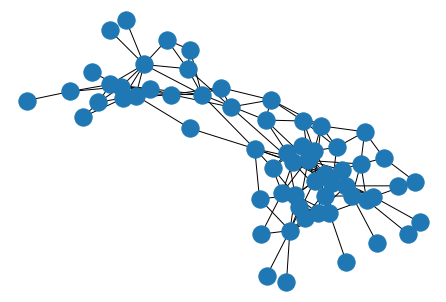

In [57]:
nx.draw(G)

In [58]:
VS = np.zeros(10**5)
IG = np.zeros(10**5)
N = len(G)

for i in trange(10**5):
    node_list = np.random.choice(range(N),size=(N//2),replace=False)
    parties = {n:int(n in node_list) for n in range(N)}    
    nx.set_node_attributes(G,parties,'party')
    IG[i] = af.influence_gap(G,absolute=False)
    VS[i] = np.sum(dynamics(G,last=True))/N - 0.5
    
columns = ['IG','VS']
df = pd.DataFrame(data=np.concatenate((IG.reshape(10**5,1),
                                       VS.reshape(10**5,1)),
                                      axis=1),
                  columns=columns)
df.to_csv("Dynamics_dolphins.csv",index=False)

100%|██████████| 100000/100000 [16:31<00:00, 100.84it/s]


LinregressResult(slope=0.10672593529896288, intercept=-7.984985856575056e-06, rvalue=0.40654166209925097, pvalue=0.0, stderr=0.0007584739550506136)


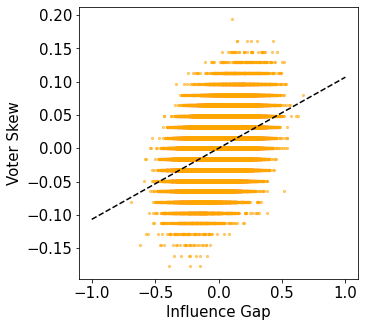

In [60]:
fig = plt.figure(figsize=(5,5))
plt.scatter(IG,VS,s=5,alpha=0.5,c='orange')
# plt.ylim([-0.2,0.2])
# plt.xlim([-0.5,0.5])

r = sp.stats.linregress(IG,VS)
x = np.linspace(-1,1,100)
plt.plot(x,r.slope*x+r.intercept,'k--')
print(r)

plt.xlabel('Influence Gap')
plt.ylabel('Voter Skew')
fig.savefig("Dynamics_dolphins.png",bbox_inches='tight')

# Deterministic predictor

In [18]:
def det_predictor(g):
    T = 240 # Total length of game in seconds
    t_decision = 3.3
    t_trans = 83
    V=0.6
    
    no_decisions = int(T//3.3)+1
    ind_trans = int(83//3.3)+1
    
    mean_prob = np.sum(par_dist*np.linspace(0,1,num=11,endpoint=True),axis=2)
    party = np.zeros((no_decisions,len(g)))
    party[0,:] = list(nx.get_node_attributes(g,'party').values())
    
    for t in range(1,no_decisions):
        for n in range(len(g)):
            poll = poll_fraction(g,n)
            j = int(t<= ind_trans)
            if poll >= V:
                i = 0
            elif poll >= 1-V:
                i = 1
            else:
                i = 2
            party[t,n] = party[t-1,n]*mean_prob[i,j] + (1-party[t-1,n])*(1-mean_prob[i,j])
        party_dict = {n:round(party[t,n]) for n in range(len(g))}
        nx.set_node_attributes(g,party_dict,'party')
    
    return party

In [74]:
N = 20
p0 = 1
h = 0.3

node_list = np.random.choice(range(N),size=(N//2),replace=False)
parties = {n:int(n in node_list) for n in range(N)}    
G_base = af.homophilic_relaxed_caveman_graph(2,10,p0,h,parties)
G_sto = G_base.copy()
G_det = G_base.copy()

In [75]:
det_outcome = det_predictor(G_det)
sto = dynamics(G_sto,par_mean=True)

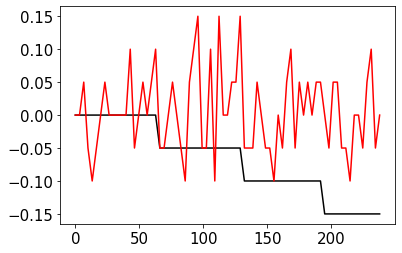

In [76]:
# for i in range(N):
#     plt.plot(np.arange(0,240,3.3),np.round(det_outcome[:,i]),'k')
#     plt.plot(np.arange(0,240,3.3),sto[:,i],'r')

plt.plot(np.arange(0,240,3.3),np.sum(np.round(det_outcome),axis=1)/N-0.5,'k')
plt.plot(np.arange(0,240,3.3),np.sum(sto,axis=1)/N-0.5,'r')

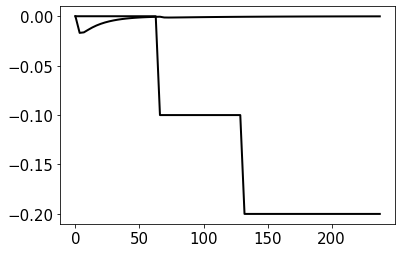

In [65]:
# for n in range(N):
#     plt.plot(np.arange(0,240,3.3),det_outcome[:,n])
    
plt.plot(np.arange(0,240,3.3),np.sum(det_outcome,axis=1)/N-0.5,'k',lw=2)
plt.plot(np.arange(0,240,3.3),np.sum(np.round(det_outcome),axis=1)/N-0.5,'k',lw=2)

# alpha > 0

In [21]:
N = 20

p0 = 1
h = 0.3
voter_skew = np.zeros(10**5)
IG = np.zeros(10**5)

for i in trange(10**5):
    node_list = np.random.choice(range(N),size=(N//2),replace=False)
    parties = {n:int(n in node_list) for n in range(N)}    
    G = af.homophilic_relaxed_caveman_graph(2,10,p0,h,parties)
    IG[i] = af.influence_gap(G,absolute=False,alpha=0.05)
    voter_skew[i] = np.sum(dynamics(G,last=True))/N - 0.5
    
columns = ['IG','VS']
df = pd.DataFrame(data=np.concatenate((IG.reshape(10**5,1),voter_skew.reshape(10**5,1)),axis=1),columns=columns)
df.to_csv("Dynamics_hRC_alpha005.csv",index=False)

100%|██████████| 100000/100000 [10:31<00:00, 158.36it/s]


LinregressResult(slope=0.08638078237627536, intercept=-0.00036658892592053224, rvalue=0.1892182583792032, pvalue=0.0, stderr=0.0014175591829536417)


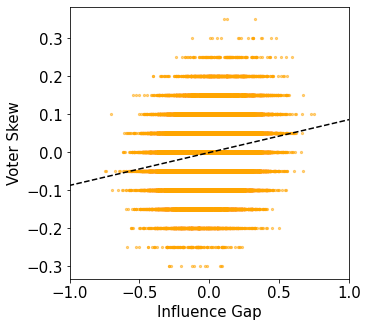

In [22]:
df = pd.read_csv("Dynamics_hRC_alpha005.csv")
IG = df['IG']
VS = df['VS']

fig = plt.figure(figsize=(5,5))
plt.scatter(IG,VS,s=5,alpha=0.5,c='orange')
# plt.ylim([-0.2,0.2])
plt.xlim([-1,1])

r = sp.stats.linregress(IG,VS)
print(r)
x = np.linspace(-2,2,100)
plt.plot(x,r.slope*x+r.intercept,'k--')

plt.xlabel('Influence Gap')
plt.ylabel('Voter Skew')
fig.savefig("Dynamics_hRC_alpha005.png",bbox_inches='tight')

In [18]:
df = pd.read_csv("Dynamics_hRC_alpha00.csv")
IG = df['IG']
VS = df['VS']
print(sp.stats.linregress(IG,VS).rvalue)

df = pd.read_csv("Dynamics_hRC_alpha01.csv")
IG = df['IG']
VS = df['VS']
print(sp.stats.linregress(IG,VS).rvalue)

df = pd.read_csv("Dynamics_hRC_alpha02.csv")
IG = df['IG']
VS = df['VS']
print(sp.stats.linregress(IG,VS).rvalue)

df = pd.read_csv("Dynamics_hRC_alpha03.csv")
IG = df['IG']
VS = df['VS']
print(sp.stats.linregress(IG,VS).rvalue)

0.16189921926945303
0.24058783014777332
0.12502307227823037
0.020515059560604145


In [28]:
df = pd.read_csv("CSVs/Dynamics_hRC_peak2.csv")
IG = df['IG']
VS = df['VS']
print(sp.stats.linregress(IG,VS).rvalue)

0.160285442593571


# Initial majority of 1

In [13]:
for majority in range(6):
    N = 20
    p0 = 0.9
    h = 0.3
    voter_skew = np.zeros(10**5)
    IG = np.zeros(10**5)
#     majority = 0

    for i in trange(10**5):
        node_list = np.random.choice(range(N),size=(N//2+majority),replace=False)
        parties = {n:int(n in node_list) for n in range(N)}    
        G = af.homophilic_relaxed_caveman_graph(2,10,p0,h,parties)
        IG[i] = af.influence_gap(G,absolute=False)
        voter_skew[i] = np.sum(dynamics(G,last=True))/N - 0.5

    columns = ['IG','VS']
    df = pd.DataFrame(data=np.concatenate((IG.reshape(10**5,1),voter_skew.reshape(10**5,1)),axis=1),columns=columns)
    df.to_csv('Dynamics_hRC_p09_majority'+str(majority)+'.csv',index=False)

100%|██████████| 100000/100000 [09:40<00:00, 172.26it/s]


LinregressResult(slope=0.11957546724449274, intercept=0.15495209553072462, rvalue=0.15579841700534575, pvalue=0.0, stderr=0.002397438733545601)


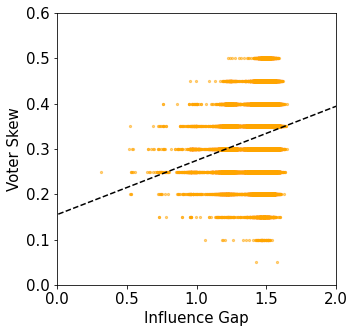

In [16]:
df = pd.read_csv("Dynamics_hRC_p09_majority5.csv")
IG = df['IG']
VS = df['VS']

fig = plt.figure(figsize=(5,5))
plt.scatter(IG,VS,s=5,alpha=0.5,c='orange')
plt.ylim([0,0.6])
plt.xlim([0,2])

r = sp.stats.linregress(IG,VS)
print(r)
x = np.linspace(-2,2,100)
plt.plot(x,r.slope*x+r.intercept,'k--')

plt.xlabel('Influence Gap')
plt.ylabel('Voter Skew')
fig.savefig("Dynamics_hRC_p09_majority5.png",bbox_inches='tight')

In [17]:
file_name = 'Dynamics_hRC_majority'
r = np.zeros(6)
for i in range(1,6):
    df = pd.read_csv(file_name+str(i)+'.csv')
    IG = df['IG']
    VS = df['VS']
    r[i] = sp.stats.linregress(IG,VS).rvalue
    
df = pd.read_csv("CSVs/Dynamics_hRC_peak2.csv")
IG = df['IG']
VS = df['VS']
r[0] = sp.stats.linregress(IG,VS).rvalue

file_name = 'Dynamics_hRC_clique_majority'
r_clique = np.zeros(6)
for i in range(6):
    df = pd.read_csv(file_name+str(i)+'.csv')
    IG = df['IG']
    VS = df['VS']
    r_clique[i] = sp.stats.linregress(IG,VS).rvalue
    
file_name = 'Dynamics_hRC_p01_majority'
r_p01 = np.zeros(6)
for i in range(6):
    df = pd.read_csv(file_name+str(i)+'.csv')
    IG = df['IG']
    VS = df['VS']
    r_p01[i] = sp.stats.linregress(IG,VS).rvalue
    
file_name = 'Dynamics_hRC_p05_majority'
r_p05 = np.zeros(6)
for i in range(6):
    df = pd.read_csv(file_name+str(i)+'.csv')
    IG = df['IG']
    VS = df['VS']
    r_p05[i] = sp.stats.linregress(IG,VS).rvalue
    
file_name = 'Dynamics_hRC_p09_majority'
r_p09 = np.zeros(6)
for i in range(6):
    df = pd.read_csv(file_name+str(i)+'.csv')
    IG = df['IG']
    VS = df['VS']
    r_p09[i] = sp.stats.linregress(IG,VS).rvalue

In [19]:
r_all = np.array([r_clique,r_p01,r_p05,r_p09,r])

(5, 6)

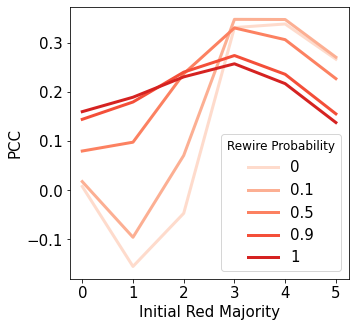

In [45]:
fig = plt.figure(figsize=(5,5))
sns.set_palette('Reds')
# sns.set_palette(sns.cubehelix_palette(5))
labels=[0,0.1,0.5,0.9,1]
for i in range(5):
    plt.plot(np.arange(6),r_all[i,:],lw=3,label=labels[i])
plt.xlabel("Initial Red Majority")
plt.ylabel("PCC")
plt.legend(title="Rewire Probability")
plt.rcParams['legend.title_fontsize'] = 12
fig.savefig("PCC_Majority.png",bbox_inches='tight')

# Low rewire

In [22]:
N = 50

p0 = 0.1
h = 0.5
voter_skew = np.zeros(10**5)
IG = np.zeros(10**5)

for i in trange(10**5):
    node_list = np.random.choice(range(N),size=(N//2),replace=False)
    parties = {n:int(n in node_list) for n in range(N)}    
    G = af.homophilic_relaxed_caveman_graph(10,5,p0,h,parties)
    IG[i] = af.influence_gap(G,absolute=False)
    voter_skew[i] = np.sum(dynamics(G,last=True))/N - 0.5
    
columns = ['IG','VS']
df = pd.DataFrame(data=np.concatenate((IG.reshape(10**5,1),voter_skew.reshape(10**5,1)),axis=1),columns=columns)
df.to_csv("Dynamics_hRC_N50_l10_p01_h05.csv",index=False)

100%|██████████| 100000/100000 [15:51<00:00, 105.05it/s]


In [23]:
df = pd.read_csv("Dynamics_hRC_N50_l10_p01_h05.csv")
IG = df['IG']
VS = df['VS']

fig = plt.figure(figsize=(5,5))
plt.scatter(IG,VS,s=5,alpha=0.5,c='orange')
plt.ylim([-0.2,0.2])
plt.xlim([-.7,.7])

r = sp.stats.linregress(IG,VS)
print(r)
x = np.linspace(-2,2,100)
plt.plot(x,r.slope*x+r.intercept,'k--',lw=1)

plt.xlabel('Influence Gap')
plt.ylabel('Voter Skew')
fig.savefig("Dynamics_hRC_N50_l10_p01_h05.png",bbox_inches='tight')

# More initial majority

In [5]:
VS = np.zeros((10**5,4))
IG = np.zeros((10**5,4))
columns = ['IG6','IG7','IG8','IG9',
           'VS6','VS7','VS8','VS9']
N = 20
h = 0.3
for p0 in [0,0.1,0.5,0.9,1]:
    for majority in trange(6,10):
        for i in range(10**5):
            node_list = np.random.choice(range(N),size=(N//2+majority),replace=False)
            parties = {n:int(n in node_list) for n in range(N)}    
            G = af.homophilic_relaxed_caveman_graph(2,10,p0,h,parties)
            IG[i,majority-6] = af.influence_gap(G,absolute=False)
            VS[i,majority-6] = np.sum(dynamics(G,last=True))/N - 0.5

    df = pd.DataFrame(data=np.concatenate((IG,VS),axis=1),columns=columns)
    df.to_csv('Dynamics_hRC_majority6to9_p'+str(p0)+'.csv',index=False)

100%|██████████| 4/4 [33:53<00:00, 508.32s/it]


In [13]:
r = np.zeros((5,10))
for i,p0 in enumerate([0,0.1,0.5,0.9,1]):
    df = pd.read_csv('CSVs/Dynamics_hRC_majority_N50_l10_p'+str(p0)+'.csv')
    for j in range(1,6):
        r[i,j-1] = sp.stats.linregress(df['IG'+str(j)],df['VS'+str(j)]).rvalue
    
    df = pd.read_csv('Dynamics_hRC_majority6to9_N50_l10_p'+str(p0)+'.csv')
    for j in range(6,11):
        r[i,j-1] = sp.stats.linregress(df['IG'+str(j)],df['VS'+str(j)]).rvalue

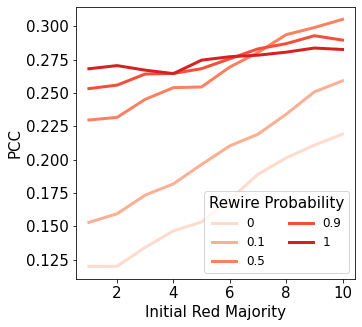

In [15]:
fig = plt.figure(figsize=(5,5))
sns.set_palette('Reds')
p0 = [0,0.1,0.5,0.9,1]
for i in range(5):
    plt.plot(np.arange(1,11),r[i,:],label=p0[i],lw=3)
plt.xlabel("Initial Red Majority")
plt.ylabel("PCC")
plt.legend(title="Rewire Probability",ncol=2,fontsize=12)
plt.rcParams['legend.title_fontsize'] = 12

fig.savefig("PCC_Majority_N50_l10.png",bbox_inches='tight')

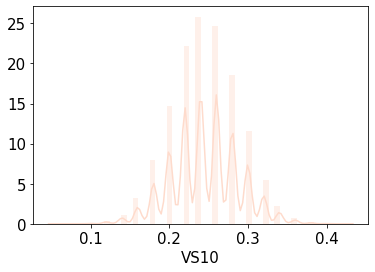

In [16]:
df = pd.read_csv('Dynamics_hRC_majority6to9_N50_l10_p1.csv')
sns.distplot(df['VS10'])

In [46]:
df = pd.read_csv("CSVs/Dynamics_BA.csv")
IG = df['IG']
VS = df['VS']
print(sp.stats.linregress(IG,VS))

LinregressResult(slope=0.08304692681296073, intercept=-0.0001713397536411288, rvalue=0.5550313831130974, pvalue=0.0, stderr=0.0012447545702882403)


# Stats

In [16]:
IG = np.zeros((10**5,10))
VS = np.zeros((10**5,10))

columns=['IG'+str(n) for n in range(10)] + ['VS'+str(n) for n in range(10)]

start = 'CSVs/Dynamics_hRC'
for majority in range(6):
    df = pd.read_csv(start+'_clique_majority'+str(majority)+'.csv')
    IG[:,majority] = df['IG']
    VS[:,majority] = df['VS']

df = pd.read_csv('Dynamics_hRC_majority6to9_p0.csv')
for majority in range(6,10):
    IG[:,majority] = df['IG'+str(majority)]
    VS[:,majority] = df['VS'+str(majority)]
df = pd.DataFrame(data=np.concatenate((IG,VS),axis=1),columns=columns)
df.to_csv('Dynamics_hRC_majority_p0.csv',index=False)

In [21]:
columns=['IG'+str(n) for n in range(10)] + ['VS'+str(n) for n in range(10)]
p_to5 = ['01','05','09']
p_to10 = ['0.1','0.5','0.9']

start = 'CSVs/Dynamics_hRC'
for i in trange(3):
    IG = np.zeros((10**5,10))
    VS = np.zeros((10**5,10))
    for majority in range(6):
        df = pd.read_csv(start+'_p'+p_to5[i]+'_majority'+str(majority)+'.csv')
        IG[:,majority] = df['IG']
        VS[:,majority] = df['VS']

    df = pd.read_csv('Dynamics_hRC_majority6to9_p'+p_to10[i]+'.csv')
    for majority in range(6,10):
        IG[:,majority] = df['IG'+str(majority)]
        VS[:,majority] = df['VS'+str(majority)]
    df = pd.DataFrame(data=np.concatenate((IG,VS),axis=1),columns=columns)
    df.to_csv('Dynamics_hRC_majority_p'+p_to10[i]+'.csv',index=False)

100%|██████████| 3/3 [00:07<00:00,  2.48s/it]


In [22]:
IG = np.zeros((10**5,10))
VS = np.zeros((10**5,10))
df = pd.read_csv('CSVs/Dynamics_hRC_peak2.csv')
IG[:,0] = df['IG']
VS[:,0] = df['VS']
for majority in range(1,6):
    df = pd.read_csv(start+'_majority'+str(majority)+'.csv')
    IG[:,majority] = df['IG']
    VS[:,majority] = df['VS']
    
df = pd.read_csv('Dynamics_hRC_majority6to9_p1.csv')
for majority in range(6,10):
    IG[:,majority] = df['IG'+str(majority)]
    VS[:,majority] = df['VS'+str(majority)]
    
df = pd.DataFrame(data=np.concatenate((IG,VS),axis=1),columns=columns)
df.to_csv('Dynamics_hRC_majority_p1.csv',index=False)

In [118]:
r = np.zeros((5,10))
for i,p0 in enumerate([0,0.1,0.5,0.9,1]):
    df = pd.read_csv('Dynamics Majority N20 h03/Dynamics_hRC_majority_p'+str(p0)+'.csv')
    for j in range(10):
        r[i,j] = sp.stats.linregress(df['IG'+str(j)],df['VS'+str(j)]).rvalue

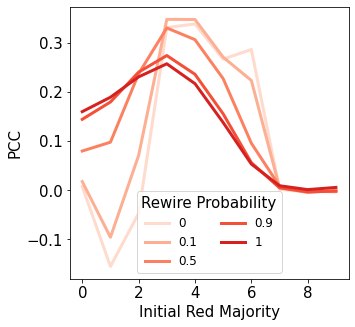

In [119]:
fig = plt.figure(figsize=(5,5))
sns.set_palette('Reds')
p0 = [0,0.1,0.5,0.9,1]
for i in range(5):
    plt.plot(np.arange(10),r[i,:],label=p0[i],lw=3)
plt.xlabel("Initial Red Majority")
plt.ylabel("PCC")
plt.legend(title="Rewire Probability",ncol=2,fontsize=12)
plt.rcParams['legend.title_fontsize'] = 12

fig.savefig("PCC_Majority.png",bbox_inches='tight')

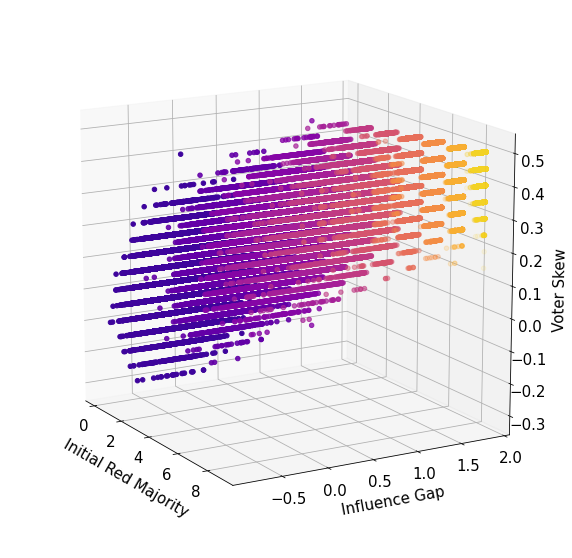

In [42]:
sns.set_palette('plasma',10)
df = pd.read_csv('Dynamics Majority N20 h03/Dynamics_hRC_majority_p1.csv')
# %matplotlib notebook
fig = plt.figure(figsize=(10,10))
ax=fig.add_subplot(111,projection='3d')
ax.view_init(15,-30)
for i in range(10):
    ax.scatter(i,df['IG'+str(i)],df['VS'+str(i)],alpha=(10-i)/10)
# plt.colorbar()
ax.set_xlabel("Initial Red Majority",labelpad=10)
ax.set_ylabel("Influence Gap",labelpad=10)
ax.set_zlabel("Voter Skew",labelpad=10)

fig.savefig("Majority_IG_VS_p1_h03_3D.png",bbox_inches='tight')

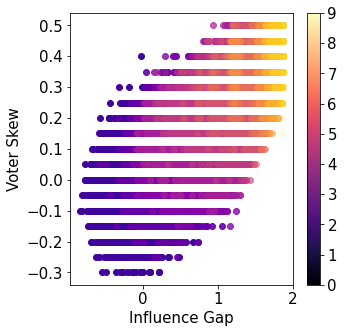

In [52]:
fig = plt.figure(figsize=(5,5))
sns.set_palette('plasma',10)
for i in range(10):
    plt.scatter(df['IG'+str(i)],df['VS'+str(i)],alpha=(10-i)/10)
    
plt.xlabel("Influence Gap")
plt.ylabel("Voter Skew")
sm = plt.cm.ScalarMappable(cmap='magma', norm=plt.Normalize(vmin=0, vmax=9))
plt.colorbar(sm)

In [105]:
IG = np.zeros(5*10**6)
VS = np.zeros(5*10**6)
Majority = []
for i in range(10):
    Majority+=[i]*10**5
Majority=np.array(Majority*5)
p0 = np.array([0]*10**6+[0.1]*10**6+[0.5]*10**6+[0.9]*10**6+[1]*10**6)

In [91]:
rewire = [0,0.1,0.5,0.9,1]
for i in range(5):
    df = pd.read_csv('Dynamics Majority N20 h03/Dynamics_hRC_majority_p'+str(rewire[i])+'.csv')
    for j in range(10):
        start_ind = i*10**6 + j*10**5
        IG[start_ind:start_ind+10**5] = df['IG'+str(j)]
        VS[start_ind:start_ind+10**5] = df['VS'+str(j)]

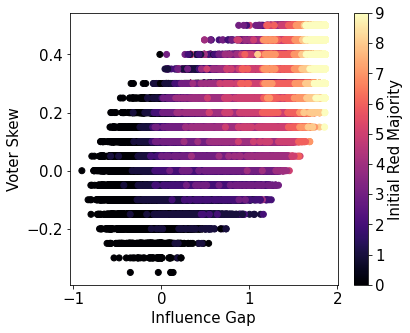

In [99]:
fig=plt.figure(figsize=(6,5))
plt.scatter(IG,VS,c=Majority,cmap='magma',vmin=-2,vmax=11)
plt.xlabel("Influence Gap")
plt.ylabel("Voter Skew")
plt.colorbar(label="Initial Red Majority")
plt.clim([0,9])

In [100]:
fig.savefig("Majority_IG_VS_p1_h03.png",bbox_inches='tight')

In [107]:
df = pd.DataFrame(data=(np.concatenate((IG.reshape(5*10**6,1),VS.reshape(5*10**6,1),
                                        Majority.reshape(5*10**6,1),
                                        p0.reshape(5*10**6,1)),axis=1)),
                  columns=['IG','VS','Majority','Rewire'])
df.to_csv("Dynamics_hRC_majority_supreme.csv",index=False)

/home/jbara/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


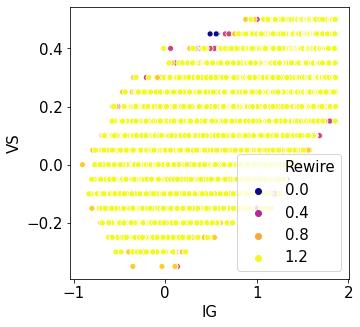

In [11]:
df = pd.read_csv("CSVs/Dynamics/Dynamics Majority N20 h03/Dynamics_hRC_majority_supreme.csv")
# sns.set_palette('plasma',10)
fig = plt.figure(figsize=(5,5))
ax=sns.scatterplot(x='IG',y='VS',hue='Rewire',data=df,
                   palette='plasma')

# Using plotly to draw

In [4]:
# Standard plotly imports
# import plotly.plotly as py
import plotly.graph_objs as go
import plotly.express as px
# from plotly.offline import iplot, init_notebook_mode
# Using plotly + cufflinks in offline mode
# import cufflinks
# cufflinks.go_offline(connected=True)
# init_notebook_mode(connected=True)

In [5]:
df = pd.read_csv("CSVs/Dynamics/Dynamics Majority N20 h03/Dynamics_hRC_majority_supreme.csv")

In [ ]:
# fig = px.scatter(df,x="IG",y="VS",color="Majority",hover_data=["Rewire"])
fig = go.Figure(data=go.Scattergl(
    x=df['IG'],
    y=df['VS'],
    mode='markers',marker_color=df['Majority'],text=df['Rewire']))
fig.update_layout(title='Influence Gap as predictor of Voter Skew')
# fig.show()

In [ ]:
fig.show()

In [14]:
df = pd.read_csv("Dynamics/Correlation/Dynamics Majority N20 h03/Dynamics_hRC_majority_supreme.csv")
print("IG-VS", sp.stats.linregress(df['IG'],df['VS']))
print("Maj-VS", sp.stats.linregress(df['Majority'],df['VS']))

IG-VS LinregressResult(slope=0.2286521288528499, intercept=-0.0030101311655611473, rvalue=0.8905451717927412, pvalue=0.0, stderr=5.2233048279150723e-05)
Maj-VS LinregressResult(slope=0.04972603212121118, intercept=0.044580065454549844, rvalue=0.9040251965990052, pvalue=0.0, stderr=1.0515582063408363e-05)


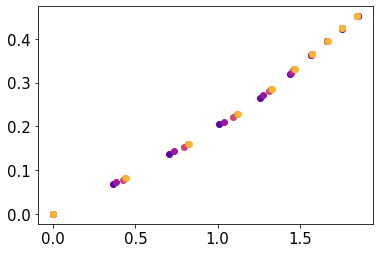

In [24]:
sns.set_palette('plasma',5)
for p0 in [0,0.1,0.5,0.9,1]:
    IG = np.zeros(10)
    VS = np.zeros(10)
    IG_err = np.zeros(10)
    VS_err = np.zeros(10)
    for majority in range(10):
        IG[majority] = df['IG'][(df['Majority']==majority)&(df['Rewire']==p0)].mean()
        VS[majority] = df['VS'][(df['Majority']==majority)&(df['Rewire']==p0)].mean()
        IG_err[majority] = df['IG'][(df['Majority']==majority)&(df['Rewire']==p0)].std()
        VS_err[majority] = df['VS'][(df['Majority']==majority)&(df['Rewire']==p0)].std()
#     plt.errorbar(range(10),IG,yerr=IG_err,marker='x')
#     plt.errorbar(range(10),VS,yerr=VS_err,marker='o')
    plt.scatter(IG,VS)
    

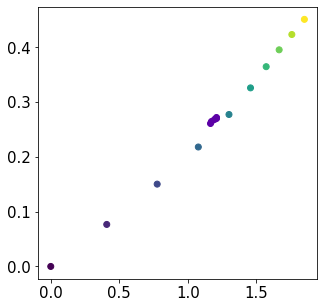

In [37]:
fig = plt.figure(figsize=(5,5))
IG = np.zeros(10)
VS = np.zeros(10)
for majority in range(10):
    IG[majority] = df['IG'][df['Majority']==majority].mean()
    VS[majority] = df['VS'][df['Majority']==majority].mean()
plt.scatter(IG,VS,c=range(10))

IG = np.zeros(5)
VS = np.zeros(5)
for i,p0 in enumerate([0,0.1,0.5,0.9,1]):
    IG[i] = df['IG'][df['Rewire']==p0].mean()
    VS[i] = df['VS'][df['Rewire']==p0].mean()
plt.scatter(IG,VS)

In [4]:
print(sp.stats.linregress(df[df['Rewire']==0]['IG'],df[df['Rewire']==0]['VS']))
print(sp.stats.linregress(df[df['Rewire']==0]['Majority'],df[df['Rewire']==0]['VS']))

LinregressResult(slope=0.2175947963686576, intercept=0.010017805533489077, rvalue=0.878955471107551, pvalue=0.0, stderr=0.00011806274922749334)
LinregressResult(slope=0.05066658787878875, intercept=0.03480085454545062, rvalue=0.9179174780594197, pvalue=0.0, stderr=2.1900738368061277e-05)


Text(0, 0.5, 'Voter Skew')

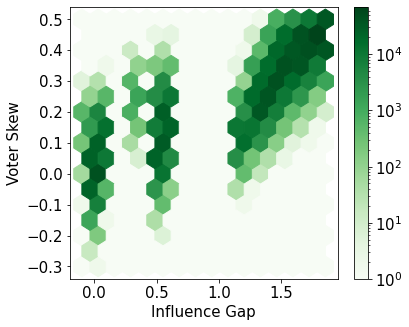

In [2]:
df = pd.read_csv("Dynamics/Correlation/Dynamics Majority N20 h03/Dynamics_hRC_majority_supreme.csv")
fig=plt.figure(figsize=(6,5))
plt.hexbin(x='IG',y='VS',gridsize=15,bins='log',cmap='Greens',data=df[df['Rewire']==0])#,extent=(-2,2,-0.5,0.5))
plt.colorbar()
plt.xlabel("Influence Gap")
plt.ylabel("Voter Skew")
# plt.xlim(-2,2)
# plt.ylim(-0.5,0.5)
# fig.savefig("Majority_IG_VS_h03_hex.png",bbox_inches='tight')

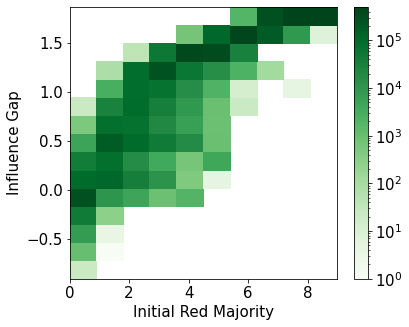

In [8]:
df = pd.read_csv("Dynamics/Correlation/Dynamics Majority N20 h03/Dynamics_hRC_majority_supreme.csv")
fig=plt.figure(figsize=(6,5))
import matplotlib.colors as colors
# plt.hexbin(x='Majority',y='IG',gridsize=15,bins='log',cmap='Greens',data=df)#,extent=(-2,2,-0.5,0.5))
plt.hist2d(x='Majority',y='IG',cmap='Greens',data=df,bins=[10, 15],norm=colors.LogNorm())
plt.colorbar()
plt.xlabel("Initial Red Majority")
plt.ylabel("Influence Gap")
# plt.xlim(-2,2)
# plt.ylim(-0.5,0.5)
fig.savefig("hRC_h03_initial_majority_IG.png",bbox_inches='tight')

In [9]:
print(sp.stats.linregress(df['Majority'],df['IG']))
print(sp.stats.linregress(df['Majority'],df['VS']))

LinregressResult(slope=0.1951281610701751, intercept=0.30869263756436516, rvalue=0.910827168482544, pvalue=0.0, stderr=3.9548138120885594e-05)
LinregressResult(slope=0.04972603212121118, intercept=0.044580065454549844, rvalue=0.9040251965990052, pvalue=0.0, stderr=1.0515582063408363e-05)


In [42]:
print(sp.stats.linregress(df['IG'][df['Rewire']==1],df['VS'][df['Rewire']==0]))
print(sp.stats.linregress(df['Majority'][df['Rewire']==1],df['VS'][df['Rewire']==0]))

LinregressResult(slope=0.23657704882030878, intercept=-0.02201180526780816, rvalue=0.8897001894739847, pvalue=0.0, stderr=0.0001213984656189245)
LinregressResult(slope=0.05066658787878875, intercept=0.03480085454545062, rvalue=0.9179174780594197, pvalue=0.0, stderr=2.1900738368061277e-05)


In [94]:
print((df['VS'].max()-df['VS'].min())/0.05)

17.0


# Majority on BA

In [15]:
N = 20
IG = np.zeros(5*10**5) # graph,k,majority
VS = np.zeros_like(IG)
majority=10
for k in trange(5):
    for i in range(10**5):
        g = nx.barabasi_albert_graph(N,k+1)
        node_list = np.random.choice(range(N),size=(N//2+majority),replace=False)
        parties = {n:int(n in node_list) for n in range(N)}
        nx.set_node_attributes(g,parties,'party')
        IG[i+k*10**5] = af.influence_gap(g)
        VS[i+k*10**5] = np.sum(dynamics(g,last=True))/N - 0.5
# nx.draw(g)

  0%|          | 0/5 [00:00<?, ?it/s]


IndexError: index 0 is out of bounds for axis 0 with size 0

In [16]:
node_list = np.random.choice(range(N),size=(N//2+10),replace=False)
parties = {n:int(n in node_list) for n in range(N)}    
g = af.homophilic_relaxed_caveman_graph(2,10,1,0.3,parties)

In [20]:
af.influence_gap(g)

IndexError: index 0 is out of bounds for axis 0 with size 0

In [7]:
IG_flat = np.zeros(6*5*10**5)
VS_flat = np.zeros_like(IG_flat)
for k in range(5):
    for majority in range(4,10):
        start_ind = k*6*10**5+(majority-4)*10**5
        IG_flat[start_ind:start_ind+10**5] = IG[:,k,majority]
        VS_flat[start_ind:start_ind+10**5] = VS[:,k,majority]

In [8]:
Majority = []
for i in range(4,10):
    Majority+=[i]*10**5
Majority=np.array(Majority*5)
K = np.array([1]*6*10**5 + [2]*6*10**5 + [3]*6*10**5 + [4]*6*10**5 + [5]*6*10**5)
df = pd.DataFrame(data=(np.concatenate((IG_flat.reshape(3*10**6,1),VS_flat.reshape(3*10**6,1),
                                        Majority.reshape(3*10**6,1),
                                        K.reshape(3*10**6,1)),axis=1)),
                  columns=['IG','VS','Majority','k'])
df.to_csv("Dynamics_BA_majority4to9.csv",index=False)

Text(0, 0.5, 'Voter Skew')

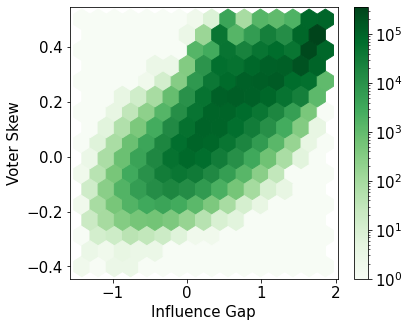

In [13]:
df=pd.read_csv("Dynamics/Correlation/Dynamics_BA_majority_supreme.csv")
fig=plt.figure(figsize=(6,5))
plt.hexbin(x='IG',y='VS',gridsize=15,bins='log',cmap='Greens',data=df)#,extent=(-2,2,-0.5,0.5))
# plt.hexbin(x='IG',y='VS',gridsize=15,bins='log',cmap='Reds',data=df[df['k']==1])
plt.colorbar()
plt.xlabel("Influence Gap")
plt.ylabel("Voter Skew")
# fig.savefig("Majority_IG_VS_BA_N20.png",bbox_inches='tight')

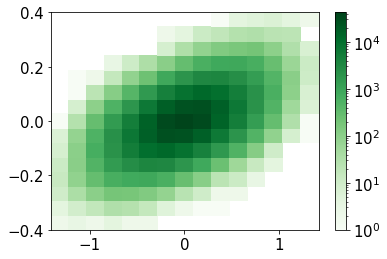

In [22]:
plt.hist2d(x='IG',y='VS',cmap='Greens',
           data=df[df['Majority']==0],bins=[15, 15],norm=colors.LogNorm());
plt.colorbar()

In [37]:
print("IG-VS",sp.stats.linregress(df['IG'],df['VS']).rvalue)
print("Maj-VS", sp.stats.linregress(df['Majority'],df['VS']).rvalue)

IG-VS 0.8276516603265048
Maj-VS 0.9131360439039302


In [24]:
df1=pd.read_csv("Dynamics_BA_majority1to3.csv")
df2=pd.read_csv("Dynamics_BA_majority4to9.csv")
df = pd.concat([df1,df2])
df.to_csv("Dynamics_BA_majority_supreme.csv",index=False)

In [56]:
np.log(2)*3/2 - np.log(3)*2/3

0.3073125783945113

# p1 h1

In [7]:
N = 20

p0 = 1
h = 1
VS = np.zeros(10**6)
IG = np.zeros(10**6)

for majority in trange(10):
    for i in range(10**5):
        node_list = np.random.choice(range(N),size=(N//2+majority),replace=False)
        parties = {n:int(n in node_list) for n in range(N)}    
        G = af.homophilic_relaxed_caveman_graph(2,10,p0,h,parties)
        IG[i+majority*10**5] = af.influence_gap(G,absolute=False)
        VS[i+majority*10**5] = np.sum(dynamics(G,last=True))/N - 0.5
    
columns = ['IG','VS','Majority']

Majority = []
for i in range(10):
    Majority+=[i]*10**5
Majority=np.array(Majority)

df = pd.DataFrame(data=np.concatenate((IG.reshape(10**6,1),VS.reshape(10**6,1),
                                      Majority.reshape(10**6,1)),axis=1),columns=columns)
df.to_csv('hRC_p'+p0+'h'+h+'.csv',index=False)

100%|██████████| 10/10 [1:36:12<00:00, 577.27s/it]


TypeError: can only concatenate str (not "int") to str

In [8]:
df = pd.DataFrame(data=np.concatenate((IG.reshape(10**6,1),VS.reshape(10**6,1),
                                      Majority.reshape(10**6,1)),axis=1),columns=columns)
df.to_csv('hRC_p'+str(p0)+'h'+str(h)+'.csv',index=False)

LinregressResult(slope=0.2239538039595542, intercept=0.038497409166129204, rvalue=0.9158250903619441, pvalue=0.0, stderr=9.820092940121338e-05)
LinregressResult(slope=0.05162011212121249, intercept=0.012846445454543803, rvalue=0.9452146707658703, pvalue=0.0, stderr=1.7828090507608975e-05)


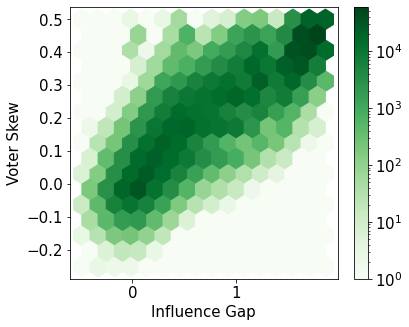

In [12]:
df=pd.read_csv("hRC_p1h1.csv")
fig=plt.figure(figsize=(6,5))
plt.hexbin(x='IG',y='VS',gridsize=15,bins='log',cmap='Greens',data=df)#,extent=(-2,2,-0.5,0.5))
# plt.hexbin(x='IG',y='VS',gridsize=15,bins='log',cmap='Reds',data=df[df['k']==1])
plt.colorbar()
plt.xlabel("Influence Gap")
plt.ylabel("Voter Skew")
fig.savefig("hRC_p1h1.png",bbox_inches='tight')

print(sp.stats.linregress(df['IG'],df['VS']))
print(sp.stats.linregress(df['Majority'],df['VS']))

# h in {0,0.2,0.4,0.6,0.8,1}
on $p_0 = 1$;
1 has been done above hRC_p1h1.csv;
0.3 has been done in the supreme.csv

In [11]:
N = 20

p0 = 1
H = [{0:1,1:0},{0:0.8,1:0.2},{0:0.6,1:0.4},{0:0.4,1:0.6},{0:0.2,1:0.8},{0:0,1:1}]
VS = np.zeros(6*10**6)
IG = np.zeros(6*10**6)

for j,h in enumerate(H):  
    for majority in trange(10):
        for i in range(10**5):
            node_list = np.random.choice(range(N),size=(N//2+majority),replace=False)
            parties = {n:int(n in node_list) for n in range(N)}    
            G = af.homophilic_relaxed_caveman_graph(2,10,p0,h,parties)
            IG[i+majority*10**5+j*10**6] = af.influence_gap(G,absolute=False)
            VS[i+majority*10**5+j*10**6] = np.sum(dynamics(G,last=True))/N - 0.5
    
columns = ['IG','VS','Majority','Homophily']

Majority = []
for i in range(10):
    Majority+=[i]*10**5
Majority=np.array(Majority*6)

h_vec = np.array([0]*10**6 +[0.2]*10**6 +[0.4]*10**6 +[0.6]*10**6 +[0.8]*10**6 +[1]*10**6)

df = pd.DataFrame(data=np.concatenate((IG.reshape(6*10**6,1),VS.reshape(6*10**6,1),
                                      Majority.reshape(6*10**6,1),
                                      h_vec.reshape(6*10**6,1)),axis=1),columns=columns)
df.to_csv('hRC_p'+str(p0)+'across_hom_ass.csv',index=False)

100%|██████████| 10/10 [1:18:31<00:00, 471.19s/it]


In [6]:
Majority = []
for i in range(10):
    Majority+=[i]*10**5
Majority=np.array(Majority*5)

df = pd.DataFrame(data=np.concatenate((IG.reshape(5*10**6,1),VS.reshape(5*10**6,1),
                                      Majority.reshape(5*10**6,1),
                                      h_vec.reshape(5*10**6,1)),axis=1),columns=columns)
df.to_csv('hRC_p'+str(p0)+'across_hom.csv',index=False)

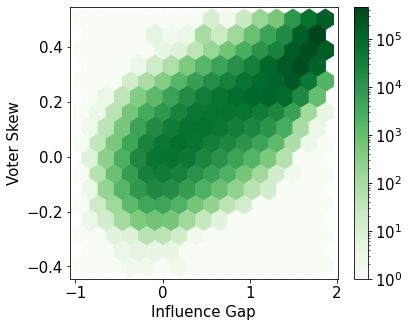

In [7]:
df=pd.read_csv("hRC_p1across_hom.csv")
fig=plt.figure(figsize=(6,5))
plt.hexbin(x='IG',y='VS',gridsize=15,bins='log',cmap='Greens',data=df)#,extent=(-2,2,-0.5,0.5))
# plt.hexbin(x='IG',y='VS',gridsize=15,bins='log',cmap='Reds',data=df[df['k']==1])
plt.colorbar()
plt.xlabel("Influence Gap")
plt.ylabel("Voter Skew")
fig.savefig("hRC_p1across_hom.png",bbox_inches='tight')

Text(0, 0.5, 'Voter Skew')

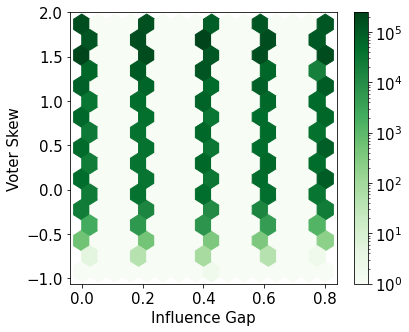

In [9]:
fig=plt.figure(figsize=(6,5))
plt.hexbin(x='Homophily',y='IG',gridsize=15,bins='log',cmap='Greens',data=df)#,extent=(-2,2,-0.5,0.5))
# plt.hexbin(x='IG',y='VS',gridsize=15,bins='log',cmap='Reds',data=df[df['k']==1])
plt.colorbar()
plt.xlabel("Influence Gap")
plt.ylabel("Voter Skew")

# Correlation Surface

In [11]:
N = 20

P0 = [0,0.2,0.4,0.6,0.8,1]
H = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
VS = np.zeros(len(P0)*len(H)*10**5)
# IG = np.zeros(5*10**5)
EG = np.zeros(len(P0)*len(H)*10**5)

for j in range(len(P0)):
    for k in trange(len(H)):
        for majority in range(10):
            for i in range(10**4):
                h = H[k]
                p0 = P0[j]
                node_list = np.random.choice(range(N),size=(N//2+majority),replace=False)
                parties = {n:int(n in node_list) for n in range(N)}    
                G = af.homophilic_relaxed_caveman_graph(2,10,p0,h,parties)
                index = i+majority*10**4+k*10**5+j*len(H)*10**5
    #             IG[index] = af.influence_gap(G,absolute=False)
                EG[index] = efficiency_gap(G)
                VS[index] = np.sum(dynamics(G,last=True))/N - 0.5
    
columns = ['VS','Majority','Homophily','Rewire','EG']

Majority = []
for i in range(10):
    Majority+=[i]*10**4
Majority=np.array(Majority*len(P0)*len(H))

Homophily = []
for i in range(len(H)):
    Homophily+=[H[i]]*10**5
Homophily=np.array(Homophily*len(P0))

Rewire = []
for i in range(len(P0)):
    Rewire+=[P0[i]]*len(H)*10**5
Rewire=np.array(Rewire)

df = pd.DataFrame(data=np.concatenate((VS.reshape(len(VS),1),
                                      Majority.reshape(len(VS),1),
                                      Homophily.reshape(len(VS),1),
                                      Rewire.reshape(len(VS),1),
                                      dVS.reshape(len(VS),1)),axis=1),columns=columns)
df.to_csv('Dynamics/Correlation/hRC_EG_surf.csv',index=False)

100%|██████████| 11/11 [1:28:04<00:00, 480.43s/it]


NameError: name 'dVS' is not defined

In [12]:
df = pd.DataFrame(data=np.concatenate((VS.reshape(len(VS),1),
                                      Majority.reshape(len(VS),1),
                                      Homophily.reshape(len(VS),1),
                                      Rewire.reshape(len(VS),1),
                                      EG.reshape(len(VS),1)),axis=1),columns=columns)
df.to_csv('Dynamics/Correlation/hRC_EG_surf.csv',index=False)

In [11]:
Majority = []
for i in range(10):
    Majority+=[i]*10**4
Majority=np.array(Majority*6)

Homophily = []
for i in range(6):
    Homophily+=[H[i]]*10**5
Homophily=np.array(Homophily)

Rewire=np.array([1]*6*10**5)

df = pd.DataFrame(data=np.concatenate((VS.reshape(6*10**5,1),
                                      Majority.reshape(6*10**5,1),
                                      Homophily.reshape(6*10**5,1),
                                      Rewire.reshape(6*10**5,1),
                                      dVS.reshape(6*10**5,1)),axis=1),columns=columns)
df.to_csv('Dynamics/Correlation/hRC_dVS_surf_p1heven.csv',index=False)

In [6]:
print(df)

                   IG    VS  Majority  Homophily  Rewire  dVS
0        5.551115e-17 -0.05       0.0        0.1     0.0  0.0
1        2.775558e-17  0.05       0.0        0.1     0.0  0.0
2        0.000000e+00  0.05       0.0        0.1     0.0  0.0
3        0.000000e+00  0.05       0.0        0.1     0.0  0.0
4        5.551115e-17  0.05       0.0        0.1     0.0  0.0
...               ...   ...       ...        ...     ...  ...
2499995  1.780197e+00  0.35       9.0        0.9     0.8  0.5
2499996  1.740037e+00  0.50       9.0        0.9     0.8  0.5
2499997  1.824288e+00  0.40       9.0        0.9     0.8  0.5
2499998  1.739823e+00  0.45       9.0        0.9     0.8  0.5
2499999  1.740643e+00  0.45       9.0        0.9     0.8  0.5

[2500000 rows x 6 columns]


# Making a gif

In [3]:
N = 20
p0 = 0.5
h = 0.3
# node_list = np.random.choice(range(N),size=(N//2),replace=False)
# parties = {n:int(n in node_list) for n in range(N)}   
# G = nx.barabasi_albert_graph(N,7)
G = nx.DiGraph()
G.add_nodes_from([n,{'party':round((n+1)/12)} for n in range(12)])

edges = [(0,11),(0,10),(0,9),
         (1,0),(1,3),(1,4),
         (2,1),(2,3),(2,4),
         ()]
nx.set_node_attributes(G,parties,'party')
# G = af.homophilic_relaxed_caveman_graph(2,10,p0,h,parties)
intentions = dynamics(G)
pos=nx.spring_layout(G)

In [10]:
print({n:round((n+1)/20) for n in range(20)})

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0, 10: 1, 11: 1, 12: 1, 13: 1, 14: 1, 15: 1, 16: 1, 17: 1, 18: 1, 19: 1}


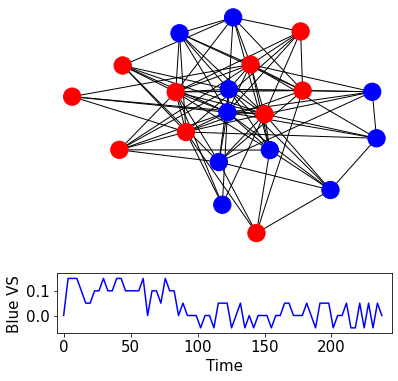

In [4]:
fig,axs=plt.subplots(2, 1, gridspec_kw={'height_ratios': [4, 1]},figsize=(6,6))
for t in range(intentions.shape[0]):
    for i in range(2):
        axs[i].clear()
    cols = [int(intentions[t,n])*'red'+(1-int(intentions[t,n]))*'blue' for n in range(N)]
    nx.draw(G,pos=pos,ax=axs[0],node_color=cols)
    axs[1].plot((np.arange(intentions.shape[0])*3.3)[:t+1],
                -intentions[:t+1,:].sum(axis=1)/N+0.5,color='blue')
    axs[1].set_xlim([-5,245])
    axs[1].set_ylim([-0.07,0.17])
    axs[1].set_xlabel("Time")
    axs[1].set_ylabel("Blue VS")
    fig.savefig('Dynamics/GIF/BA_'+str(t)+'.png',bbox_inches='tight')

In [5]:
import imageio
images = []
for t in range(intentions.shape[0]):
    images.append(imageio.imread('Dynamics/GIF/BA_'+str(t)+'.png'))
imageio.mimsave('Dynamics/GIF/BA.gif', images,duration=0.15)

# Corrections 27/5/21
A line in dynamics had been missing (forgot to update polls at each time). Checking to see if things still worked. Here's hoping it does.

In [2]:
samples = 1000
Majority = np.array(list(range(10))*1000)
IG = np.zeros(samples*10)
VS = np.zeros(samples*10)

N=20
for i in trange(10000):
    node_list = np.random.choice(range(N),size=(N//2+Majority[i]),replace=False)
    parties = {n:int(n in node_list) for n in range(N)}    
    G = af.homophilic_relaxed_caveman_graph(2,10,1,1,parties)
    IG[i] = af.influence_gap(G)
    VS[i] = np.sum(dynamics(G,last=True))/N - 0.5

100%|██████████| 10000/10000 [02:38<00:00, 63.25it/s]


In [7]:
df = pd.DataFrame(data=np.concatenate((IG.reshape(10**4,1),
                                       VS.reshape(10**4,1),
                                       Majority.reshape(10**4,1)),axis=1),
                                       columns=['IG','VS','Majority'])
df.to_csv('Dynamics/Corrections 27-5-21/hRC_h1p1.csv',index=False)

In [5]:
h = [0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1]
p = [0,0.4,1]
N=20
per_maj = 300
Majority = np.array(list(range(10))*per_maj)
samples=per_maj*10
IG = np.zeros(samples)
VS = np.zeros(samples)
dVS = np.zeros(samples)
EG = np.zeros(samples)
dfs=[]
for k in range(3):
    for j in trange(11):
        for i in range(samples):
            node_list = np.random.choice(range(N),size=(N//2+Majority[i]),replace=False)
            parties = {n:int(n in node_list) for n in range(N)}    
            # REWIRE FIRST, THEN HOMOPHILY!!!!
            G = af.homophilic_relaxed_caveman_graph(2,10,p[k],h[j],parties)
            IG[i] = af.influence_gap(G)
            dVS[i] = dVS_gap(G)
            EG[i] = efficiency_gap(G)
            election_outcome = Counter(af.dynamics(G,last=True))
            VS[i] = election_outcome[1]/N - 0.5
#             VS[i] = np.sum(dynamics(G,last=True))/N - 0.5
        df = pd.DataFrame(data=np.concatenate((IG.reshape(samples,1),
                                               VS.reshape(samples,1),
                                               Majority.reshape(samples,1),
                                               dVS.reshape(samples,1),
                                               EG.reshape(samples,1),
                                               np.array([h[j]]*samples).reshape(samples,1),
                                               np.array([p[k]]*samples).reshape(samples,1)
                                              ),axis=1),
                          columns=['IG','VS','Majority','dVS','EG','Homophily','Rewire'])
        dfs.append(df)
#         df.to_csv('Dynamics/Corrections 27-5-21/hRC_h{0}p{1}.csv'.format(h[j],p[k]),index=False)
pd.concat(dfs).to_csv('Dynamics/Corrections 27-5-21/hRC_all_samples{0}c.csv'.format(samples),
                      index=False)

100%|██████████| 11/11 [13:23<00:00, 73.07s/it]


## relaxed caveman p=0.3

In [11]:
N=20
samples = 1000
IG = np.zeros(samples)
VS = np.zeros(samples)

for i in trange(samples):
    node_list = np.random.choice(range(N),size=(N//2),replace=False)
    parties = {n:int(n in node_list) for n in range(N)}
    G = nx.relaxed_caveman_graph(2,10,0.3)
    nx.set_node_attributes(G,parties,'party')
    IG[i] = af.influence_gap(G)
    VS[i] = np.sum(af.dynamics(G,last=True))/N - 0.5

100%|██████████| 1000/1000 [00:26<00:00, 37.36it/s]


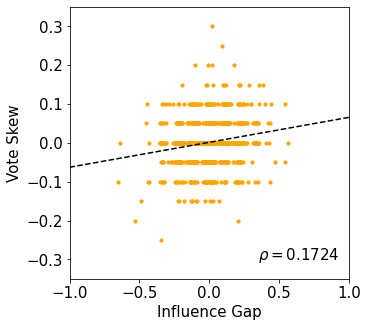

In [16]:
folder='Dynamics/Corrections 27-5-21/'
fig = plt.figure(figsize=(5,5))
plt.scatter(IG,VS,s=10,alpha=1,c='orange')
plt.ylim([-0.35,0.35])
plt.xlim([-1,1])

r = sp.stats.linregress(IG,VS)
x = np.linspace(-2,2,100)
plt.plot(x,r.slope*x+r.intercept,'k--')

plt.xlabel('Influence Gap')
plt.ylabel('Vote Skew')
plt.annotate(r'$\rho = {0}$'.format(round(r.rvalue,4)),(0.35,-0.3))
fig.savefig(folder+"Dynamics_RC_scatter_p03.png",bbox_inches='tight')

In [17]:
print(r)

LinregressResult(slope=0.06414600955680845, intercept=0.0015398827547962984, rvalue=0.17238554164895795, pvalue=4.120510064649185e-08, stderr=0.01160253261005755, intercept_stderr=0.001885118713681841)
